# Power Spectrum Analysis During Task Epochs

**Dataset**: DANDI:000673 - Control of working memory by phase-amplitude coupling

**Analysis Goals**:
1. Compute power spectra during different task epochs (encoding, maintenance, retrieval)
2. Compare spectral features across brain regions (hippocampus, amygdala, prefrontal cortex)
3. Identify region-specific frequency band signatures during working memory tasks

**Task Epochs**:
- Fixation: Pre-trial baseline
- Encoding: Visual stimulus presentation (1-3 items)
- Maintenance: Delay period (holding items in memory)
- Probe: Memory query presentation
- Response: Behavioral response window

## 1. Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# NWB
from pynwb import NWBHDF5IO
import h5py

# Signal processing
from scipy import signal, stats
from scipy.signal import welch, spectrogram, butter, filtfilt

# Statistical analysis
from scipy.stats import f_oneway, ttest_rel, mannwhitneyu
from itertools import combinations

# Parallel processing
from joblib import Parallel, delayed
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("All packages loaded successfully")

All packages loaded successfully


In [2]:
# Configuration
from nwb_analysis import (
    FREQ_BANDS, BRAIN_REGIONS, EVENT_DEFINITIONS, EVENT_SEQUENCE,
    TASK_EPOCHS, WELCH_WINDOW_SEC, WELCH_OVERLAP, FREQ_RANGE
)

DATA_DIR = Path('/Users/jundazhu/SBCAT/000673')
OUTPUT_DIR = Path('/Users/jundazhu/SBCAT/analysis_output/power_spectrum')
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"\nFrequency bands:")
for band, (low, high) in FREQ_BANDS.items():
    print(f"  {band}: {low}-{high} Hz")
print(f"\nBrain regions ({len(BRAIN_REGIONS)} total, bilateral merged):")
for region in BRAIN_REGIONS.keys():
    print(f"  - {region}")
print(f"\nTask epochs: {TASK_EPOCHS}")


# ## 2. Data Loading Functions (Reused from Existing Notebooks)


Data directory: /Users/jundazhu/SBCAT/000673
Output directory: /Users/jundazhu/SBCAT/analysis_output/power_spectrum

Frequency bands:
  delta: 1-4 Hz
  theta: 4-8 Hz
  alpha: 8-12 Hz
  beta: 12-30 Hz
  low_gamma: 30-60 Hz
  high_gamma: 60-120 Hz

Brain regions (5 total, bilateral merged):
  - Hippocampus
  - Amygdala
  - vmPFC
  - dACC
  - preSMA

Task epochs: ['fixation', 'encoding1', 'encoding2', 'encoding3', 'maintenance', 'probe', 'RT']


## 2. Data Loading Functions (Reused from Existing Notebooks)

In [3]:
# Import data loading functions
from nwb_analysis import load_lfp_safe, load_nwb_file, get_subject_files

# Test loading
all_files = get_subject_files(DATA_DIR)
print(f"Found {len(all_files)} NWB files")
print(f"Example: {all_files[4]}")

print("\nData loading functions ready!")

Found 44 NWB files
Example: /Users/jundazhu/SBCAT/000673/sub-12/sub-12_ses-1_ecephys+image.nwb

Data loading functions ready!


## 3. Brain Region Extraction

Group electrodes by anatomical location and create region-to-channel mapping.

In [4]:
# Import brain region functions
from nwb_analysis import extract_region_channels, summarize_region_coverage

# Load example file and extract regions
print("Loading example file to examine brain region coverage...\n")
example_data = load_nwb_file(all_files[0])
electrodes_df = example_data['electrodes']

# Extract region channels
region_channels, channel_to_region = extract_region_channels(electrodes_df)

# Summarize
summarize_region_coverage(region_channels, electrodes_df)

# Close file
example_data['io'].close()

print("\n✓ Brain region extraction functions ready!")

Loading example file to examine brain region coverage...

=== Brain Region Channel Coverage ===
Total electrodes: 74

Hippocampus: 14 channels
  - hippocampus_left: 7
  - hippocampus_right: 7
Amygdala: 15 channels
  - amygdala_right: 8
  - amygdala_left: 7
vmPFC: 14 channels
  - ventral_medial_prefrontal_cortex_right: 7
  - ventral_medial_prefrontal_cortex_left: 7
dACC: 16 channels
  - dorsal_anterior_cingulate_cortex_left: 8
  - dorsal_anterior_cingulate_cortex_right: 8
preSMA: 15 channels
  - pre_supplementary_motor_area_right: 8
  - pre_supplementary_motor_area_left: 7

✓ Brain region extraction functions ready!


## 4. Task Epoch Extraction

Parse trials table to extract temporal windows for each task epoch.

In [5]:
# Import epoch extraction functions
from nwb_analysis import extract_epoch_times, summarize_epochs

# Load example file and extract epochs
print("Loading example file to examine task epochs...\n")
example_data = load_nwb_file(all_files[0])
trials_df = example_data['trials']

print(f"Trials table shape: {trials_df.shape}")
print(f"Trials columns: {list(trials_df.columns)}\n")

# Extract epochs
epochs_df = extract_epoch_times(trials_df)

# Summarize
summarize_epochs(epochs_df)

# Show first few epochs
print("\nFirst 10 epochs:")
print(epochs_df.head(10))

# Close file
example_data['io'].close()

print("\n✓ Task epoch extraction functions ready!")

Loading example file to examine task epochs...

Trials table shape: (140, 19)
Trials columns: ['loads', 'PicIDs_Encoding1', 'PicIDs_Encoding2', 'PicIDs_Encoding3', 'PicIDs_Probe', 'start_time', 'stop_time', 'timestamps_FixationCross', 'timestamps_Encoding1', 'timestamps_Encoding1_end', 'timestamps_Encoding2', 'timestamps_Encoding2_end', 'timestamps_Encoding3', 'timestamps_Encoding3_end', 'timestamps_Maintenance', 'timestamps_Probe', 'timestamps_Response', 'response_accuracy', 'probe_in_out']

=== Task Epoch Summary ===
Total epochs extracted: 840

Epochs by type:
  fixation: 140
  encoding1: 140
  maintenance: 140
  probe: 140
  RT: 140
  encoding2: 70
  encoding3: 70

Epoch durations (mean ± std):
  fixation: 1.123 ± 0.100 s
  encoding1: 2.008 ± 0.002 s
  encoding2: 2.008 ± 0.001 s
  encoding3: 2.008 ± 0.001 s
  maintenance: 2.685 ± 0.081 s
  probe: 1.000 ± 0.000 s
  RT: 1.288 ± 1.032 s

Memory load distribution:
  Load 1: 350 epochs
  Load 3: 490 epochs

First 10 epochs:
   trial_id 

## 5. Visualization of Epoch Structure

Visualize the temporal structure of task epochs across trials.

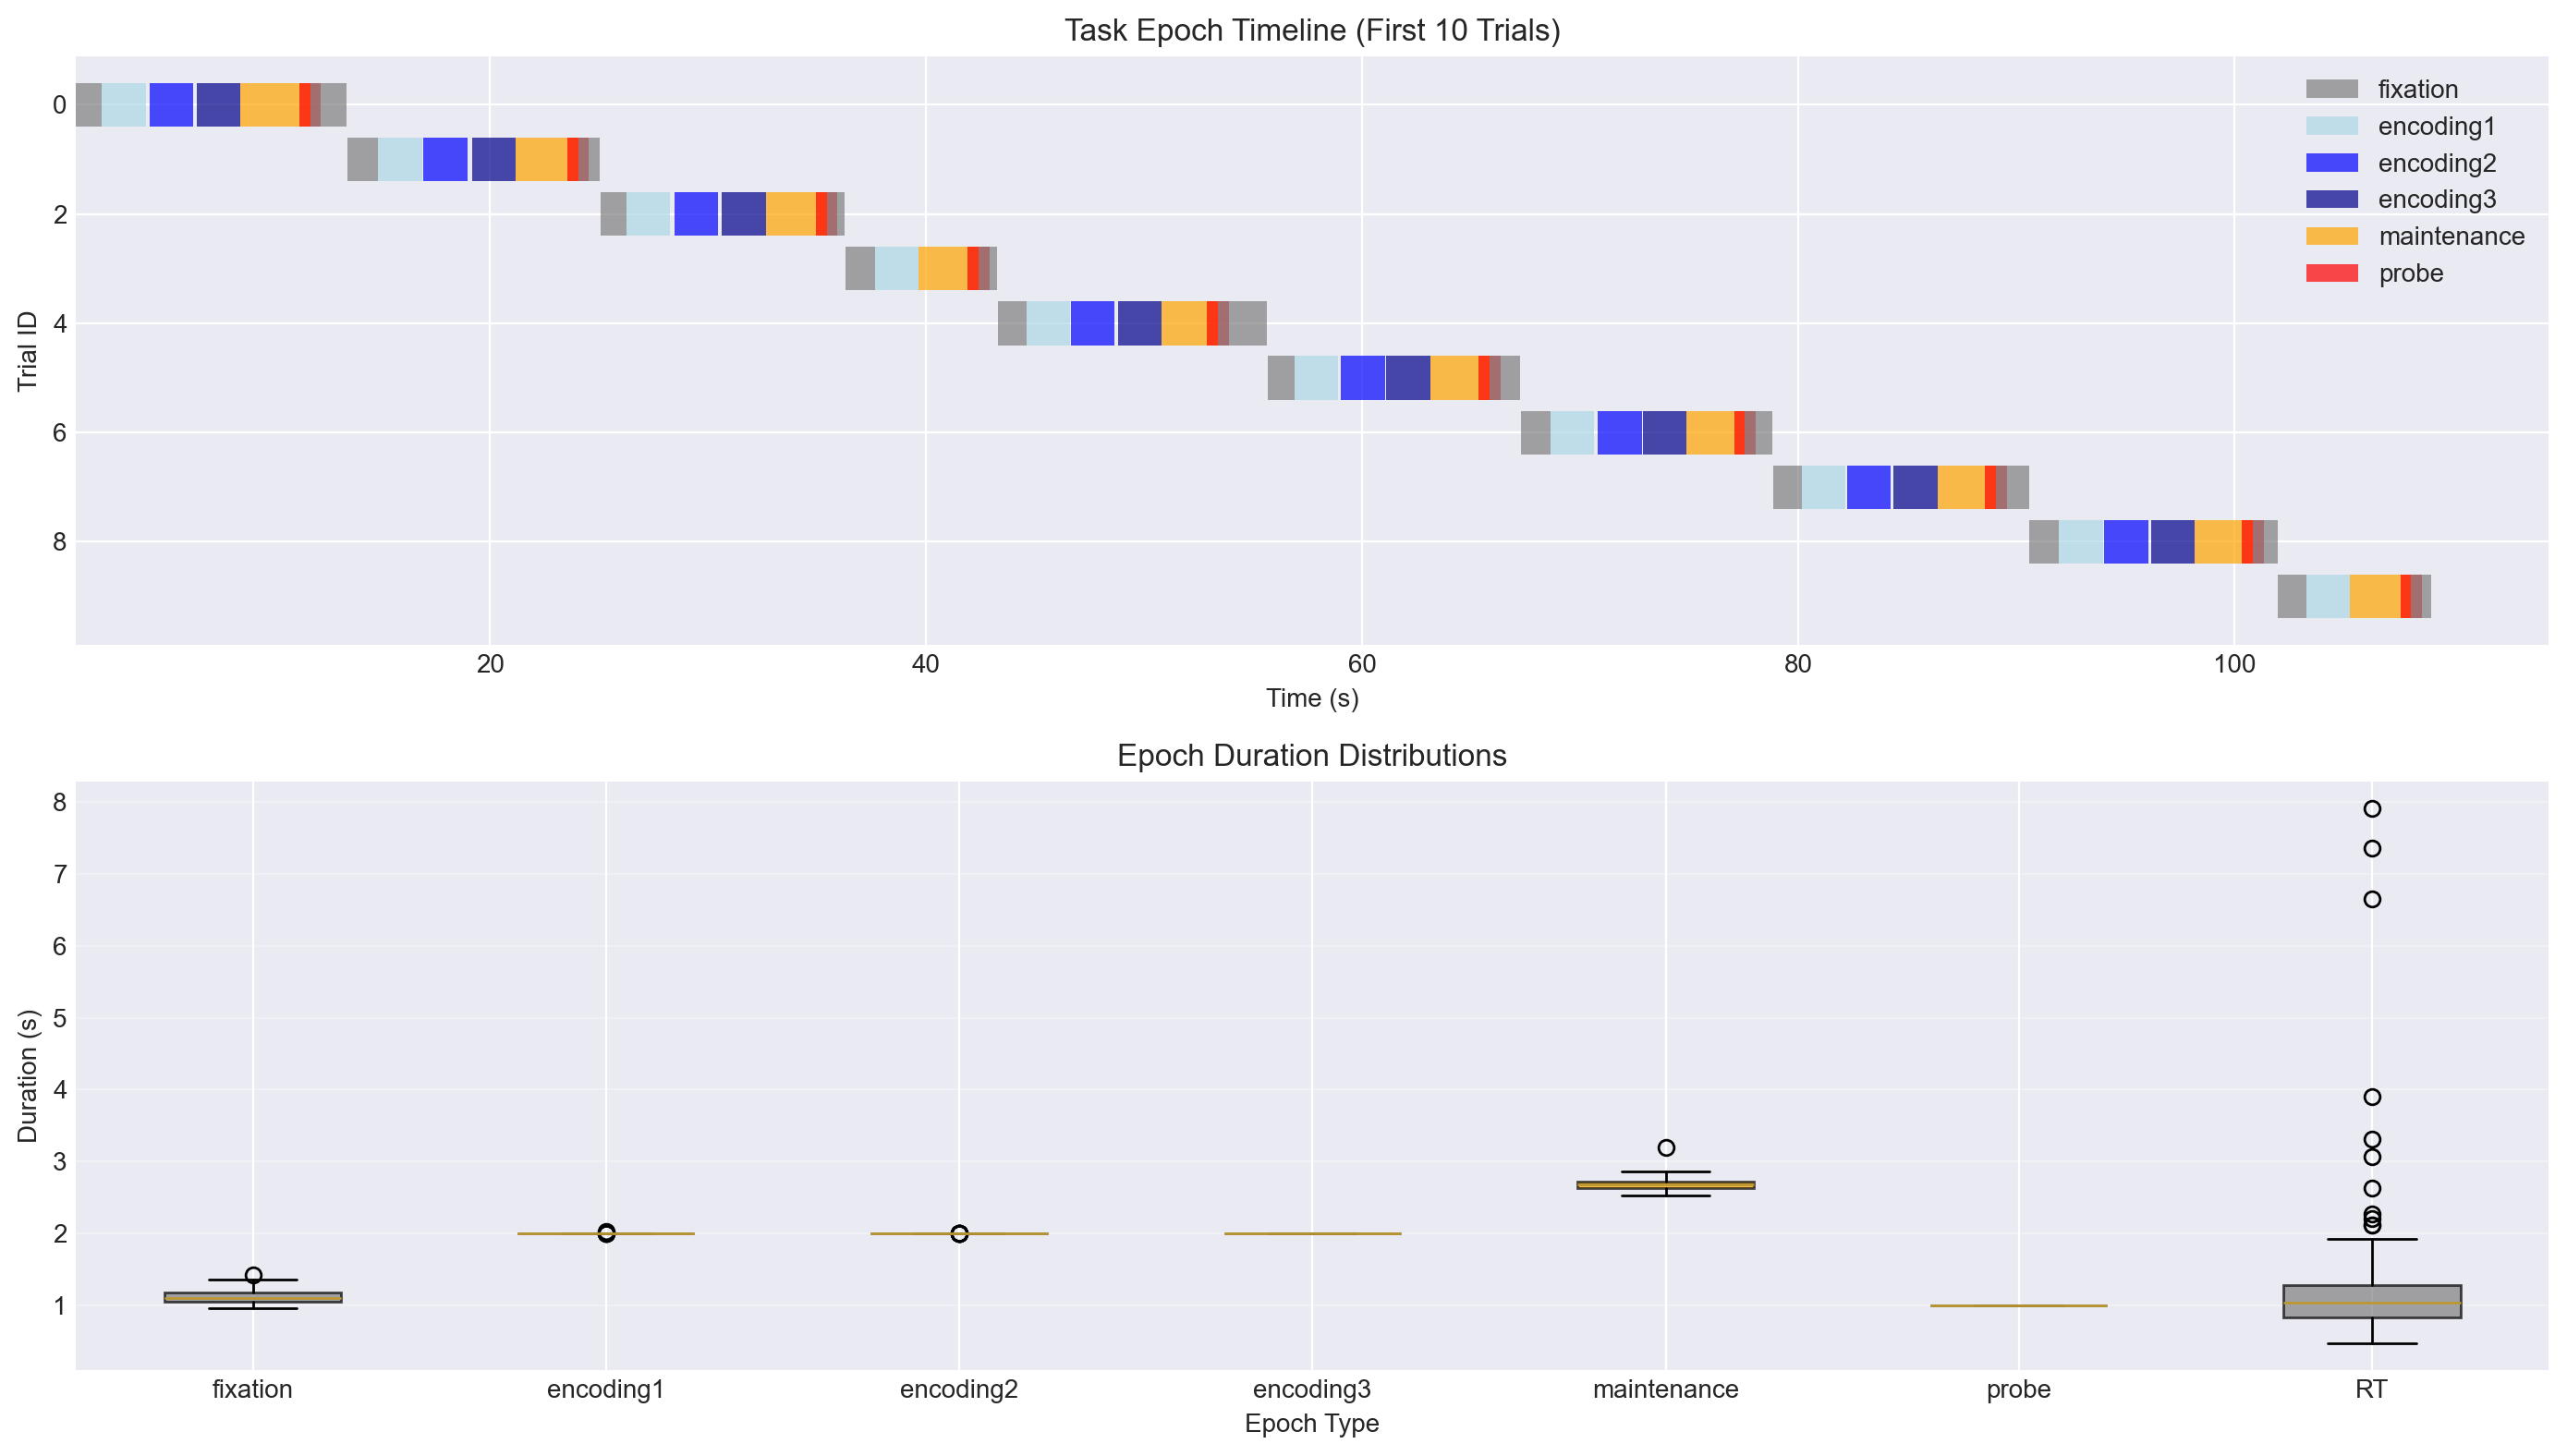

In [6]:
# Visualize epoch timing structure
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Timeline of epochs for first 10 trials
n_trials_to_plot = 10
epochs_subset = epochs_df[epochs_df['trial_id'] < n_trials_to_plot]

epoch_colors = {
    'fixation': 'gray',
    'encoding1': 'lightblue',
    'encoding2': 'blue',
    'encoding3': 'darkblue',
    'maintenance': 'orange',
    'probe': 'red'
}

for _, epoch in epochs_subset.iterrows():
    trial_id = epoch['trial_id']
    axes[0].barh(trial_id, epoch['duration'], left=epoch['start_time'],
                 height=0.8, color=epoch_colors.get(epoch['epoch_type'], 'gray'),
                 alpha=0.7)

axes[0].set_ylabel('Trial ID')
axes[0].set_xlabel('Time (s)')
axes[0].set_title(f'Task Epoch Timeline (First {n_trials_to_plot} Trials)')
axes[0].invert_yaxis()

# Create legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, alpha=0.7, label=epoch_type)
                   for epoch_type, color in epoch_colors.items()]
axes[0].legend(handles=legend_elements, loc='upper right')

# Plot 2: Duration distributions by epoch type
epoch_types = epochs_df['epoch_type'].unique()
positions = range(len(epoch_types))

durations_by_type = [epochs_df[epochs_df['epoch_type'] == et]['duration'].values
                     for et in epoch_types]

bp = axes[1].boxplot(durations_by_type, labels=epoch_types, patch_artist=True)

# Color boxes
for patch, epoch_type in zip(bp['boxes'], epoch_types):
    patch.set_facecolor(epoch_colors.get(epoch_type, 'gray'))
    patch.set_alpha(0.7)

axes[1].set_ylabel('Duration (s)')
axes[1].set_xlabel('Epoch Type')
axes[1].set_title('Epoch Duration Distributions')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
# plt.savefig(OUTPUT_DIR / 'epoch_structure.png', dpi=150, bbox_inches='tight')
plt.show()

# print(f"\n✓ Epoch visualization saved to {OUTPUT_DIR / 'epoch_structure.png'}")

## 6. Power Spectrum Computation Functions

Extract LFP segments for each epoch and compute power spectra using Welch's method.

In [7]:
# Import power spectrum computation functions
from nwb_analysis import (
    extract_lfp_epoch_segment,
    compute_psd_welch,
    compute_band_power,
    fit_1f_background
)

print("✓ Power spectrum computation functions imported!")

✓ Power spectrum computation functions imported!


In [8]:
# Import PSD analysis functions
from nwb_analysis import (
    compute_epoch_psd_for_region,
    compute_all_region_epoch_psds
)

print("✓ Region × Epoch PSD computation functions imported!")

✓ Region × Epoch PSD computation functions imported!


## 7. Load Data for Time-Frequency Analysis

Load NWB file and prepare for spectrogram computation.

In [9]:
# Load example file for analysis
print("Loading session for time-frequency analysis...")
example_file = all_files[0]
print(f"File: {example_file.name}\n")

# Load data
nwb_data = load_nwb_file(example_file)
electrodes_df = nwb_data['electrodes']
trials_df = nwb_data['trials']

# Extract regions and epochs
region_channels, channel_to_region = extract_region_channels(electrodes_df)

print(f"Session info:")
print(f"  - {len(trials_df)} trials")
print(f"  - {len(electrodes_df)} electrodes in {len(region_channels)} regions")
print(f"  - Sampling rate: {nwb_data['lfp']['sampling_rate']} Hz\n")

print("Region channel counts:")
for region_name, channels in region_channels.items():
    print(f"  {region_name}: {len(channels)} channels")

print("\n✓ Data loaded successfully!")

Loading session for time-frequency analysis...
File: sub-1_ses-1_ecephys+image.nwb

Session info:
  - 140 trials
  - 74 electrodes in 5 regions
  - Sampling rate: 400.0 Hz

Region channel counts:
  Hippocampus: 14 channels
  Amygdala: 15 channels
  vmPFC: 14 channels
  dACC: 16 channels
  preSMA: 15 channels

✓ Data loaded successfully!


## 8. Time-Frequency Spectrogram Functions

Functions for computing time-frequency spectrograms with baseline normalization and z-scoring.

In [10]:
# Import event-aligned segment extraction function
from nwb_analysis import extract_event_aligned_segments

print("✓ Event-aligned window extraction function imported!")


✓ Event-aligned window extraction function imported!


In [11]:
# Import spectrogram functions
from nwb_analysis import (
    compute_spectrogram_by_groups_stft,
    compute_spectrogram_by_groups_cwt,
    plot_spectrogram_by_groups
)

print("✓ Spectrogram functions imported!")


✓ Spectrogram functions imported!


## 9. Test Load-Based Trial Grouping

Test the new `group_trials_by_load()` function before using it in section 10.

In [12]:
# Reload the nwb_analysis module to get the latest changes
import importlib
import nwb_analysis
importlib.reload(nwb_analysis)

# Re-import specific modules that may have been updated
import nwb_analysis.epochs
importlib.reload(nwb_analysis.epochs)

print("✓ Module reloaded successfully!")

✓ Module reloaded successfully!


In [13]:
# Import the new function
from nwb_analysis import group_trials_by_load

# Test it with our trials_df (which was loaded in section 7)
print("Testing group_trials_by_load() function...\n")

# Group trials by load
load_groups = group_trials_by_load(trials_df)

# Print the summary
print(load_groups['summary'])
print()

# Show detailed info
print("Detailed group information:")
for load_val, label, group_indices, count in zip(
    load_groups['load_values'], 
    load_groups['group_labels'],
    load_groups['groups'],
    load_groups['group_counts']
):
    print(f"\n{label}:")
    print(f"  Count: {count} trials")
    print(f"  Indices (first 10): {group_indices[:10]}")
    print(f"  Index array shape: {group_indices.shape}")
    print(f"  Index array type: {type(group_indices)}")

print("\n✓ Function test complete! Ready to use in section 10.")

Testing group_trials_by_load() function...

=== Trial Grouping by Memory Load ===
Total trials: 140
Number of groups: 2

  Load 1: 70 trials
  Load 3: 70 trials

Detailed group information:

Load 1:
  Count: 70 trials
  Indices (first 10): [ 3  9 10 13 15 18 21 28 29 30]
  Index array shape: (70,)
  Index array type: <class 'numpy.ndarray'>

Load 3:
  Count: 70 trials
  Indices (first 10): [ 0  1  2  4  5  6  7  8 11 12]
  Index array shape: (70,)
  Index array type: <class 'numpy.ndarray'>

✓ Function test complete! Ready to use in section 10.


## 11. Grand-Averaged Spectrogram Analysis Across All Sessions

This section extends section 10 to analyze multiple sessions:
1. Loop over all session files
2. Compute spectrograms for each session (with session-wide baseline normalization)
3. Pool z-scored spectrograms across all sessions
4. Plot grand-averaged results

In [14]:
# Session Selection: Choose which sessions to process
print("="*70)
print("SESSION SELECTION")
print("="*70)
print()

print(f"Available sessions: {len(all_files)}")
print()

# Show all available sessions
print("All sessions:")
for i, f in enumerate(all_files):
    print(f"  [{i:2d}] {f.name}")

print()
print("-"*70)

# ===== EDIT THIS SECTION TO SELECT SESSIONS =====

all_files_to_process = all_files[:]

# all_files_to_process = [f for f in all_files if '20140603' in f.name]

# =================================================

print()
print(f"Selected {len(all_files_to_process)} session(s) to process:")
for i, f in enumerate(all_files_to_process):
    print(f"  [{i}] {f.name}")

print()
print("="*70)

SESSION SELECTION

Available sessions: 44

All sessions:
  [ 0] sub-1_ses-1_ecephys+image.nwb
  [ 1] sub-1_ses-2_ecephys+image.nwb
  [ 2] sub-10_ses-1_ecephys+image.nwb
  [ 3] sub-11_ses-1_ecephys+image.nwb
  [ 4] sub-12_ses-1_ecephys+image.nwb
  [ 5] sub-12_ses-2_ecephys+image.nwb
  [ 6] sub-13_ses-1_ecephys+image.nwb
  [ 7] sub-14_ses-1_ecephys+image.nwb
  [ 8] sub-15_ses-1_ecephys+image.nwb
  [ 9] sub-16_ses-1_ecephys+image.nwb
  [10] sub-17_ses-1_ecephys+image.nwb
  [11] sub-18_ses-1_ecephys+image.nwb
  [12] sub-19_ses-1_ecephys+image.nwb
  [13] sub-19_ses-2_ecephys+image.nwb
  [14] sub-2_ses-1_ecephys+image.nwb
  [15] sub-20_ses-1_ecephys+image.nwb
  [16] sub-21_ses-1_ecephys+image.nwb
  [17] sub-22_ses-1_ecephys+image.nwb
  [18] sub-22_ses-2_ecephys+image.nwb
  [19] sub-22_ses-3_ecephys+image.nwb
  [20] sub-23_ses-1_ecephys+image.nwb
  [21] sub-24_ses-1_ecephys+image.nwb
  [22] sub-25_ses-1_ecephys+image.nwb
  [23] sub-26_ses-1_ecephys+image.nwb
  [24] sub-26_ses-2_ecephys+image.

In [15]:
# Step 1: Initialize storage structure for pooling across sessions
print("="*70)
print("GRAND-AVERAGED SPECTROGRAM ANALYSIS ACROSS ALL SESSIONS")
print("="*70)
print()

# Configuration
regions_to_analyze = ['Hippocampus', 'Amygdala', 'vmPFC', 'dACC', 'preSMA']
freq_range = (1, 140)
n_freqs = 14

# Storage: {region_name: {'load_1': [specs], 'load_3': [specs], 'freqs': ..., 'times': ...}}
pooled_spectrograms = {}
for region_name in regions_to_analyze:
    pooled_spectrograms[region_name] = {
        'load_1_specs': [],
        'load_3_specs': [],
        'freqs': None,
        'times': None,
        'session_ids': [],
        'n_trials_per_session': {'load_1': [], 'load_3': []}
    }

print(f"Regions to analyze: {regions_to_analyze}")
print(f"Frequency range: {freq_range[0]}-{freq_range[1]} Hz")
print(f"Number of frequency bins: {n_freqs}")
print(f"Total sessions to process: {len(all_files_to_process)}")
print()
print("✓ Storage structure initialized")

GRAND-AVERAGED SPECTROGRAM ANALYSIS ACROSS ALL SESSIONS

Regions to analyze: ['Hippocampus', 'Amygdala', 'vmPFC', 'dACC', 'preSMA']
Frequency range: 1-140 Hz
Number of frequency bins: 14
Total sessions to process: 44

✓ Storage structure initialized


In [16]:
# Step 2: Loop over all sessions and collect CHANNEL-LEVEL z-scored spectrograms
from nwb_analysis import load_nwb_file, extract_region_channels, group_trials_by_load
from nwb_analysis import compute_spectrogram_by_groups_stft

print("="*70)
print("STEP 2: PROCESSING SESSIONS (CHANNEL-LEVEL)")
print("="*70)
print()

n_sessions_processed = 0
n_sessions_skipped = 0

for session_idx, session_file in enumerate(tqdm(all_files_to_process, desc="Processing sessions")):
    try:
        # Load session
        nwb_data = load_nwb_file(session_file)
        trials_df = nwb_data['trials']
        electrodes_df = nwb_data['electrodes']
        
        # Extract regions
        region_channels_session, _ = extract_region_channels(electrodes_df)
        
        # Group trials by load
        load_groups = group_trials_by_load(trials_df)
        
        # Check if session has both load conditions
        if len(load_groups['groups']) < 2:
            print(f"\nSkipping {session_file.name}: insufficient load groups")
            n_sessions_skipped += 1
            nwb_data['io'].close()
            continue
        
        session_has_data = False
        
        # Process each region
        for region_name in regions_to_analyze:
            if region_name not in region_channels_session or len(region_channels_session[region_name]) == 0:
                continue
            
            # Compute spectrograms (with session-wide baseline normalization)
            spectrogram_results = compute_spectrogram_by_groups_stft(
                nwb_data, trials_df, region_channels_session,
                region_name,
                freq_range=freq_range,
                groups=load_groups['groups'],
                n_freqs=n_freqs
            )
            
            if spectrogram_results is None or len(spectrogram_results.get('groups', [])) < 2:
                continue
            
            # Extract CHANNEL-LEVEL z-scored spectrograms for each load
            # Shape: (n_channels, n_freqs, n_times)
            load1_spec_per_channel = spectrogram_results['groups'][0]['power_zscored_per_channel']
            load3_spec_per_channel = spectrogram_results['groups'][1]['power_zscored_per_channel']
            
            # Store each channel separately (flatten across sessions and channels)
            for ch_idx in range(load1_spec_per_channel.shape[0]):
                pooled_spectrograms[region_name]['load_1_specs'].append(load1_spec_per_channel[ch_idx])
                pooled_spectrograms[region_name]['load_3_specs'].append(load3_spec_per_channel[ch_idx])
            
            # Track session info (once per region per session)
            pooled_spectrograms[region_name]['session_ids'].append(session_file.stem)
            pooled_spectrograms[region_name]['n_trials_per_session']['load_1'].append(
                spectrogram_results['groups'][0]['n_trials']
            )
            pooled_spectrograms[region_name]['n_trials_per_session']['load_3'].append(
                spectrogram_results['groups'][1]['n_trials']
            )
            
            # Store frequency and time axes (same for all sessions and channels)
            if pooled_spectrograms[region_name]['freqs'] is None:
                pooled_spectrograms[region_name]['freqs'] = spectrogram_results['groups'][0]['frequencies']
                pooled_spectrograms[region_name]['times'] = spectrogram_results['groups'][0]['time_vector']
            
            session_has_data = True
        
        if session_has_data:
            n_sessions_processed += 1
        else:
            n_sessions_skipped += 1
        
        # Close file
        nwb_data['io'].close()
        
    except Exception as e:
        print(f"\nError processing {session_file.name}: {e}")
        import traceback
        traceback.print_exc()
        n_sessions_skipped += 1
        if 'nwb_data' in locals():
            nwb_data['io'].close()
        continue

print()
print("="*70)
print(f"✓ Session processing complete!")
print(f"  Sessions processed: {n_sessions_processed}")
print(f"  Sessions skipped: {n_sessions_skipped}")
print()

# Print summary for each region
for region_name in regions_to_analyze:
    n_channels = len(pooled_spectrograms[region_name]['load_1_specs'])
    if n_channels > 0:
        total_load1_trials = sum(pooled_spectrograms[region_name]['n_trials_per_session']['load_1'])
        total_load3_trials = sum(pooled_spectrograms[region_name]['n_trials_per_session']['load_3'])
        n_sessions_region = len(pooled_spectrograms[region_name]['session_ids'])
        print(f"{region_name}:")
        print(f"  Channels: {n_channels} (from {n_sessions_region} session(s))")
        print(f"  Total Load 1 trials: {total_load1_trials}")
        print(f"  Total Load 3 trials: {total_load3_trials}")
    else:
        print(f"{region_name}: No data collected")
print("="*70)

STEP 2: PROCESSING SESSIONS (CHANNEL-LEVEL)



Processing sessions:   0%|          | 0/44 [00:00<?, ?it/s]

    Using STFT with 14 linearly-spaced frequencies
    Using 1.50s padding to reduce edge artifacts (min freq: 1 Hz)
    Computing STFT time-frequency maps for all trials (event-aligned)...
    Using STFT with 14 linearly-spaced frequencies
    Using 1.50s padding to reduce edge artifacts (min freq: 1 Hz)
    Computing STFT time-frequency maps for all trials (event-aligned)...
    Using STFT with 14 linearly-spaced frequencies
    Using 1.50s padding to reduce edge artifacts (min freq: 1 Hz)
    Computing STFT time-frequency maps for all trials (event-aligned)...
    Using STFT with 14 linearly-spaced frequencies
    Using 1.50s padding to reduce edge artifacts (min freq: 1 Hz)
    Computing STFT time-frequency maps for all trials (event-aligned)...
    Using STFT with 14 linearly-spaced frequencies
    Using 1.50s padding to reduce edge artifacts (min freq: 1 Hz)
    Computing STFT time-frequency maps for all trials (event-aligned)...
    Using STFT with 14 linearly-spaced frequencies

Traceback (most recent call last):
  File "/var/folders/m6/4rb3n3zn5l9826lx67t897qm0000gn/T/ipykernel_15223/2393272217.py", line 41, in <module>
    spectrogram_results = compute_spectrogram_by_groups_stft(
  File "/Users/jundazhu/SBCAT/nwb_analysis/spectrogram.py", line 190, in compute_spectrogram_by_groups_stft
    lfp_series = nwb_data['lfp']['series']
KeyError: 'lfp'


    Using STFT with 14 linearly-spaced frequencies
    Using 1.50s padding to reduce edge artifacts (min freq: 1 Hz)
    Computing STFT time-frequency maps for all trials (event-aligned)...
    Using STFT with 14 linearly-spaced frequencies
    Using 1.50s padding to reduce edge artifacts (min freq: 1 Hz)
    Computing STFT time-frequency maps for all trials (event-aligned)...
    Using STFT with 14 linearly-spaced frequencies
    Using 1.50s padding to reduce edge artifacts (min freq: 1 Hz)
    Computing STFT time-frequency maps for all trials (event-aligned)...
    Using STFT with 14 linearly-spaced frequencies
    Using 1.50s padding to reduce edge artifacts (min freq: 1 Hz)
    Computing STFT time-frequency maps for all trials (event-aligned)...
    Using STFT with 14 linearly-spaced frequencies
    Using 1.50s padding to reduce edge artifacts (min freq: 1 Hz)
    Computing STFT time-frequency maps for all trials (event-aligned)...
    Using STFT with 14 linearly-spaced frequencies

In [17]:
# Step 3: Average spectrograms across CHANNELS
print()
print("="*70)
print("STEP 3: AVERAGING ACROSS CHANNELS")
print("="*70)
print()

grand_averaged_results = {}

for region_name in regions_to_analyze:
    load1_specs = pooled_spectrograms[region_name]['load_1_specs']
    load3_specs = pooled_spectrograms[region_name]['load_3_specs']
    
    if len(load1_specs) == 0 or len(load3_specs) == 0:
        print(f"{region_name}: No data to average")
        continue
    
    # Convert to arrays: (n_channels, n_freqs, n_times)
    load1_specs_array = np.array(load1_specs)
    load3_specs_array = np.array(load3_specs)
    
    print(f"{region_name}:")
    print(f"  Load 1 shape: {load1_specs_array.shape}")
    print(f"  Load 3 shape: {load3_specs_array.shape}")
    
    # Grand average across channels (axis=0)
    grand_avg_load1 = np.nanmean(load1_specs_array, axis=0)
    grand_avg_load3 = np.nanmean(load3_specs_array, axis=0)
    
    # Standard error across channels
    se_load1 = np.nanstd(load1_specs_array, axis=0) / np.sqrt(load1_specs_array.shape[0])
    se_load3 = np.nanstd(load3_specs_array, axis=0) / np.sqrt(load3_specs_array.shape[0])
    
    # Store results
    grand_averaged_results[region_name] = {
        'load_1': grand_avg_load1,
        'load_3': grand_avg_load3,
        'se_load1': se_load1,
        'se_load3': se_load3,
        'freqs': pooled_spectrograms[region_name]['freqs'],
        'times': pooled_spectrograms[region_name]['times'],
        'n_channels': load1_specs_array.shape[0],
        'n_sessions': len(pooled_spectrograms[region_name]['session_ids'])
    }
    
    print(f"  Grand average computed (n={load1_specs_array.shape[0]} channels from {grand_averaged_results[region_name]['n_sessions']} session(s))")

print()
print("✓ Grand averaging complete!")
print("="*70)


STEP 3: AVERAGING ACROSS CHANNELS

Hippocampus:
  Load 1 shape: (613, 14, 235)
  Load 3 shape: (613, 14, 235)
  Grand average computed (n=613 channels from 42 session(s))
Amygdala:
  Load 1 shape: (465, 14, 235)
  Load 3 shape: (465, 14, 235)
  Grand average computed (n=465 channels from 40 session(s))
vmPFC:
  Load 1 shape: (225, 14, 235)
  Load 3 shape: (225, 14, 235)
  Grand average computed (n=225 channels from 25 session(s))
dACC:
  Load 1 shape: (330, 14, 235)
  Load 3 shape: (330, 14, 235)
  Grand average computed (n=330 channels from 27 session(s))
preSMA:
  Load 1 shape: (289, 14, 235)
  Load 3 shape: (289, 14, 235)
  Grand average computed (n=289 channels from 22 session(s))

✓ Grand averaging complete!



STEP 4: PLOTTING GRAND-AVERAGED RESULTS


Plotting Hippocampus...


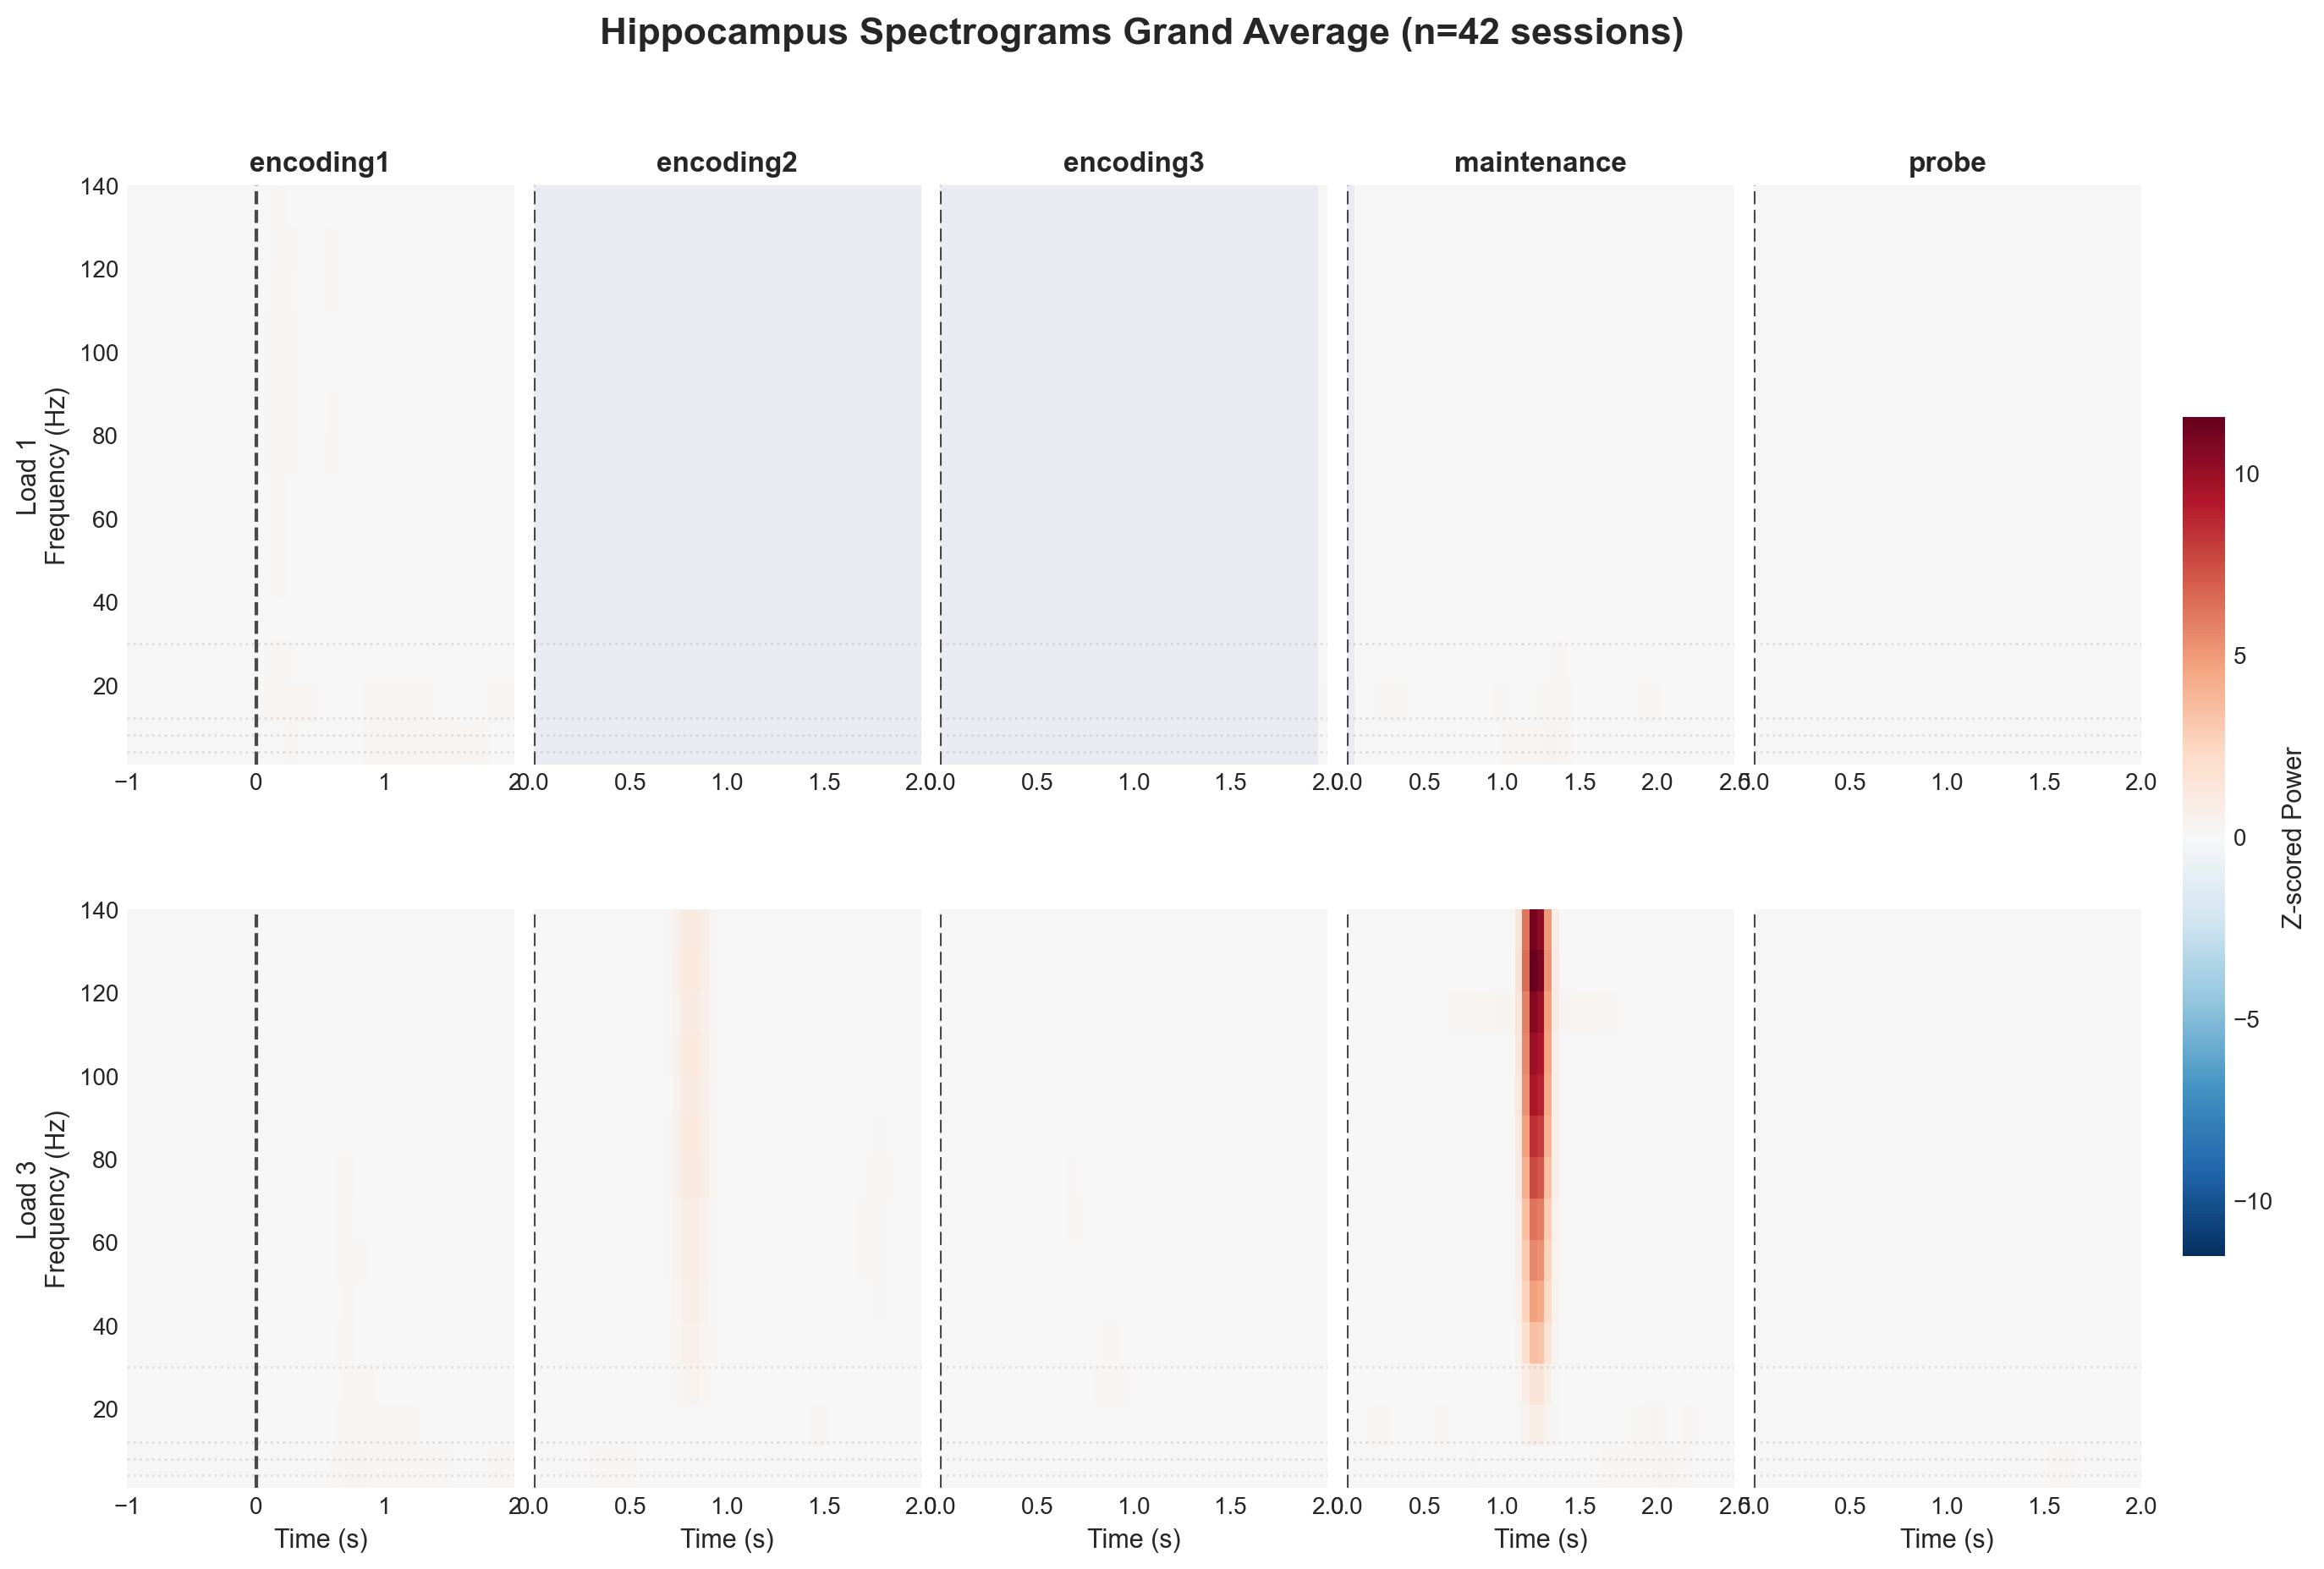

  ✓ Saved: grand_average_spectrogram_load1_vs_load3_Hippocampus_n42.png

Plotting Amygdala...


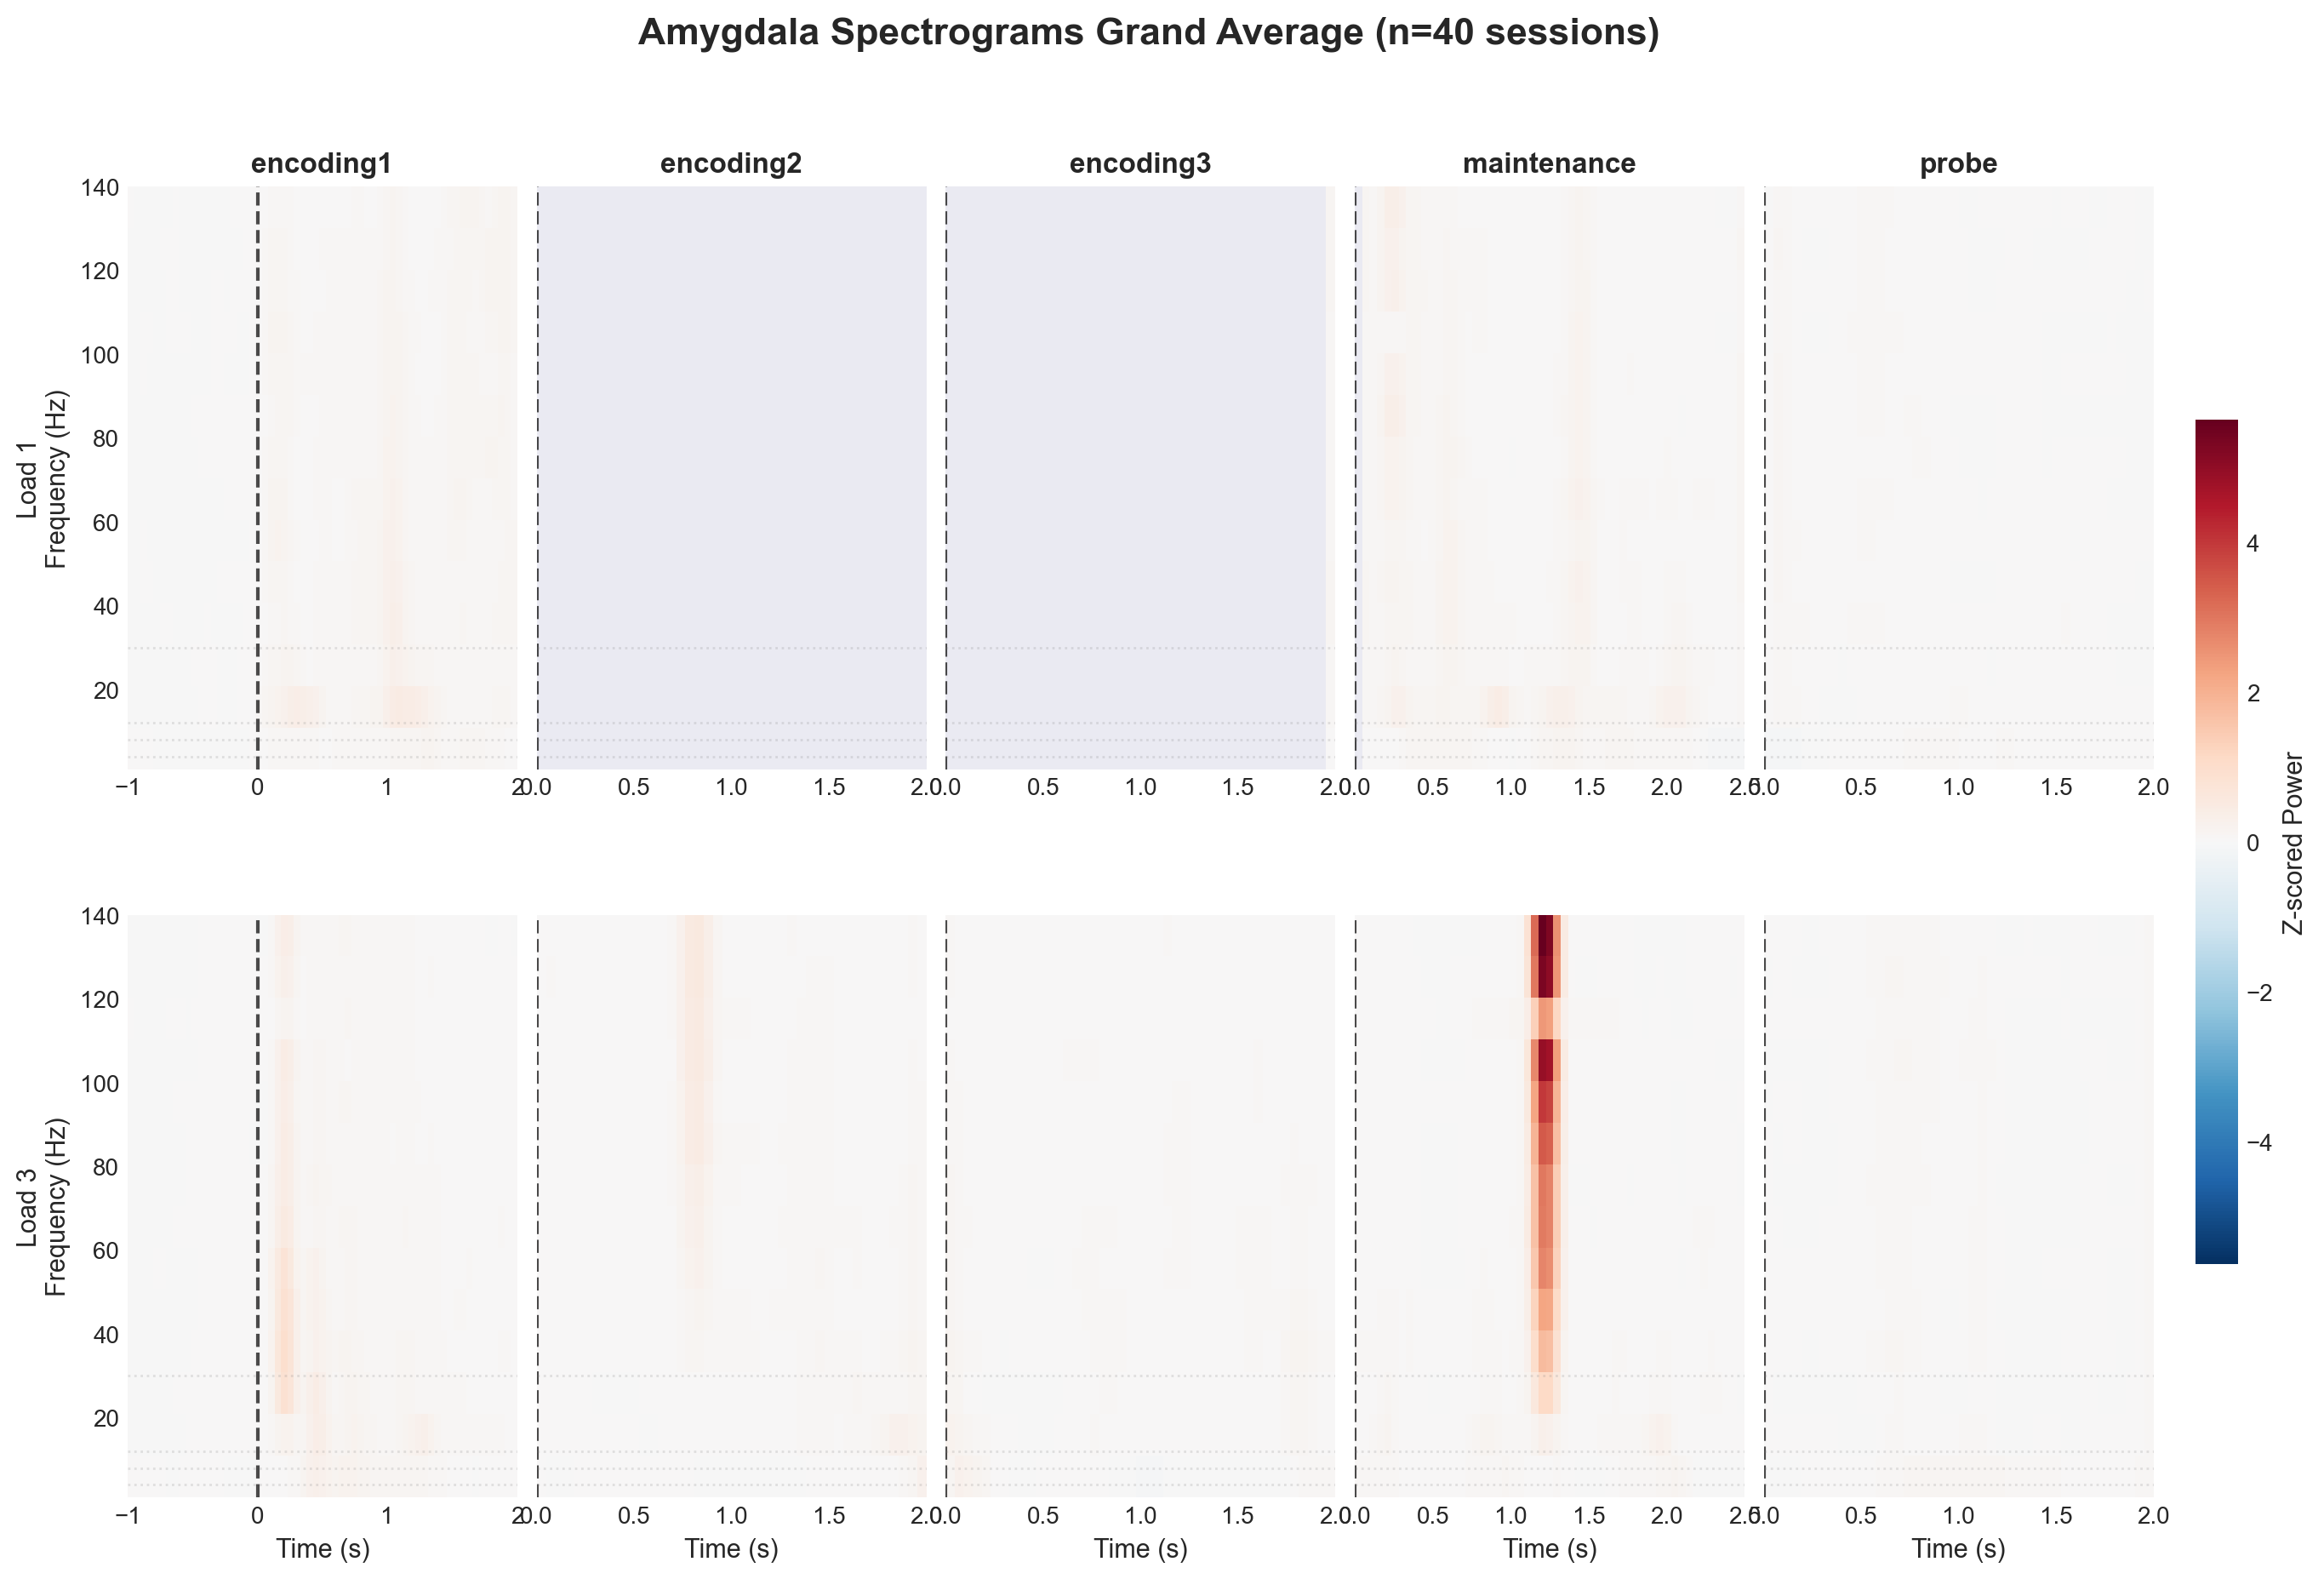

  ✓ Saved: grand_average_spectrogram_load1_vs_load3_Amygdala_n40.png

Plotting vmPFC...


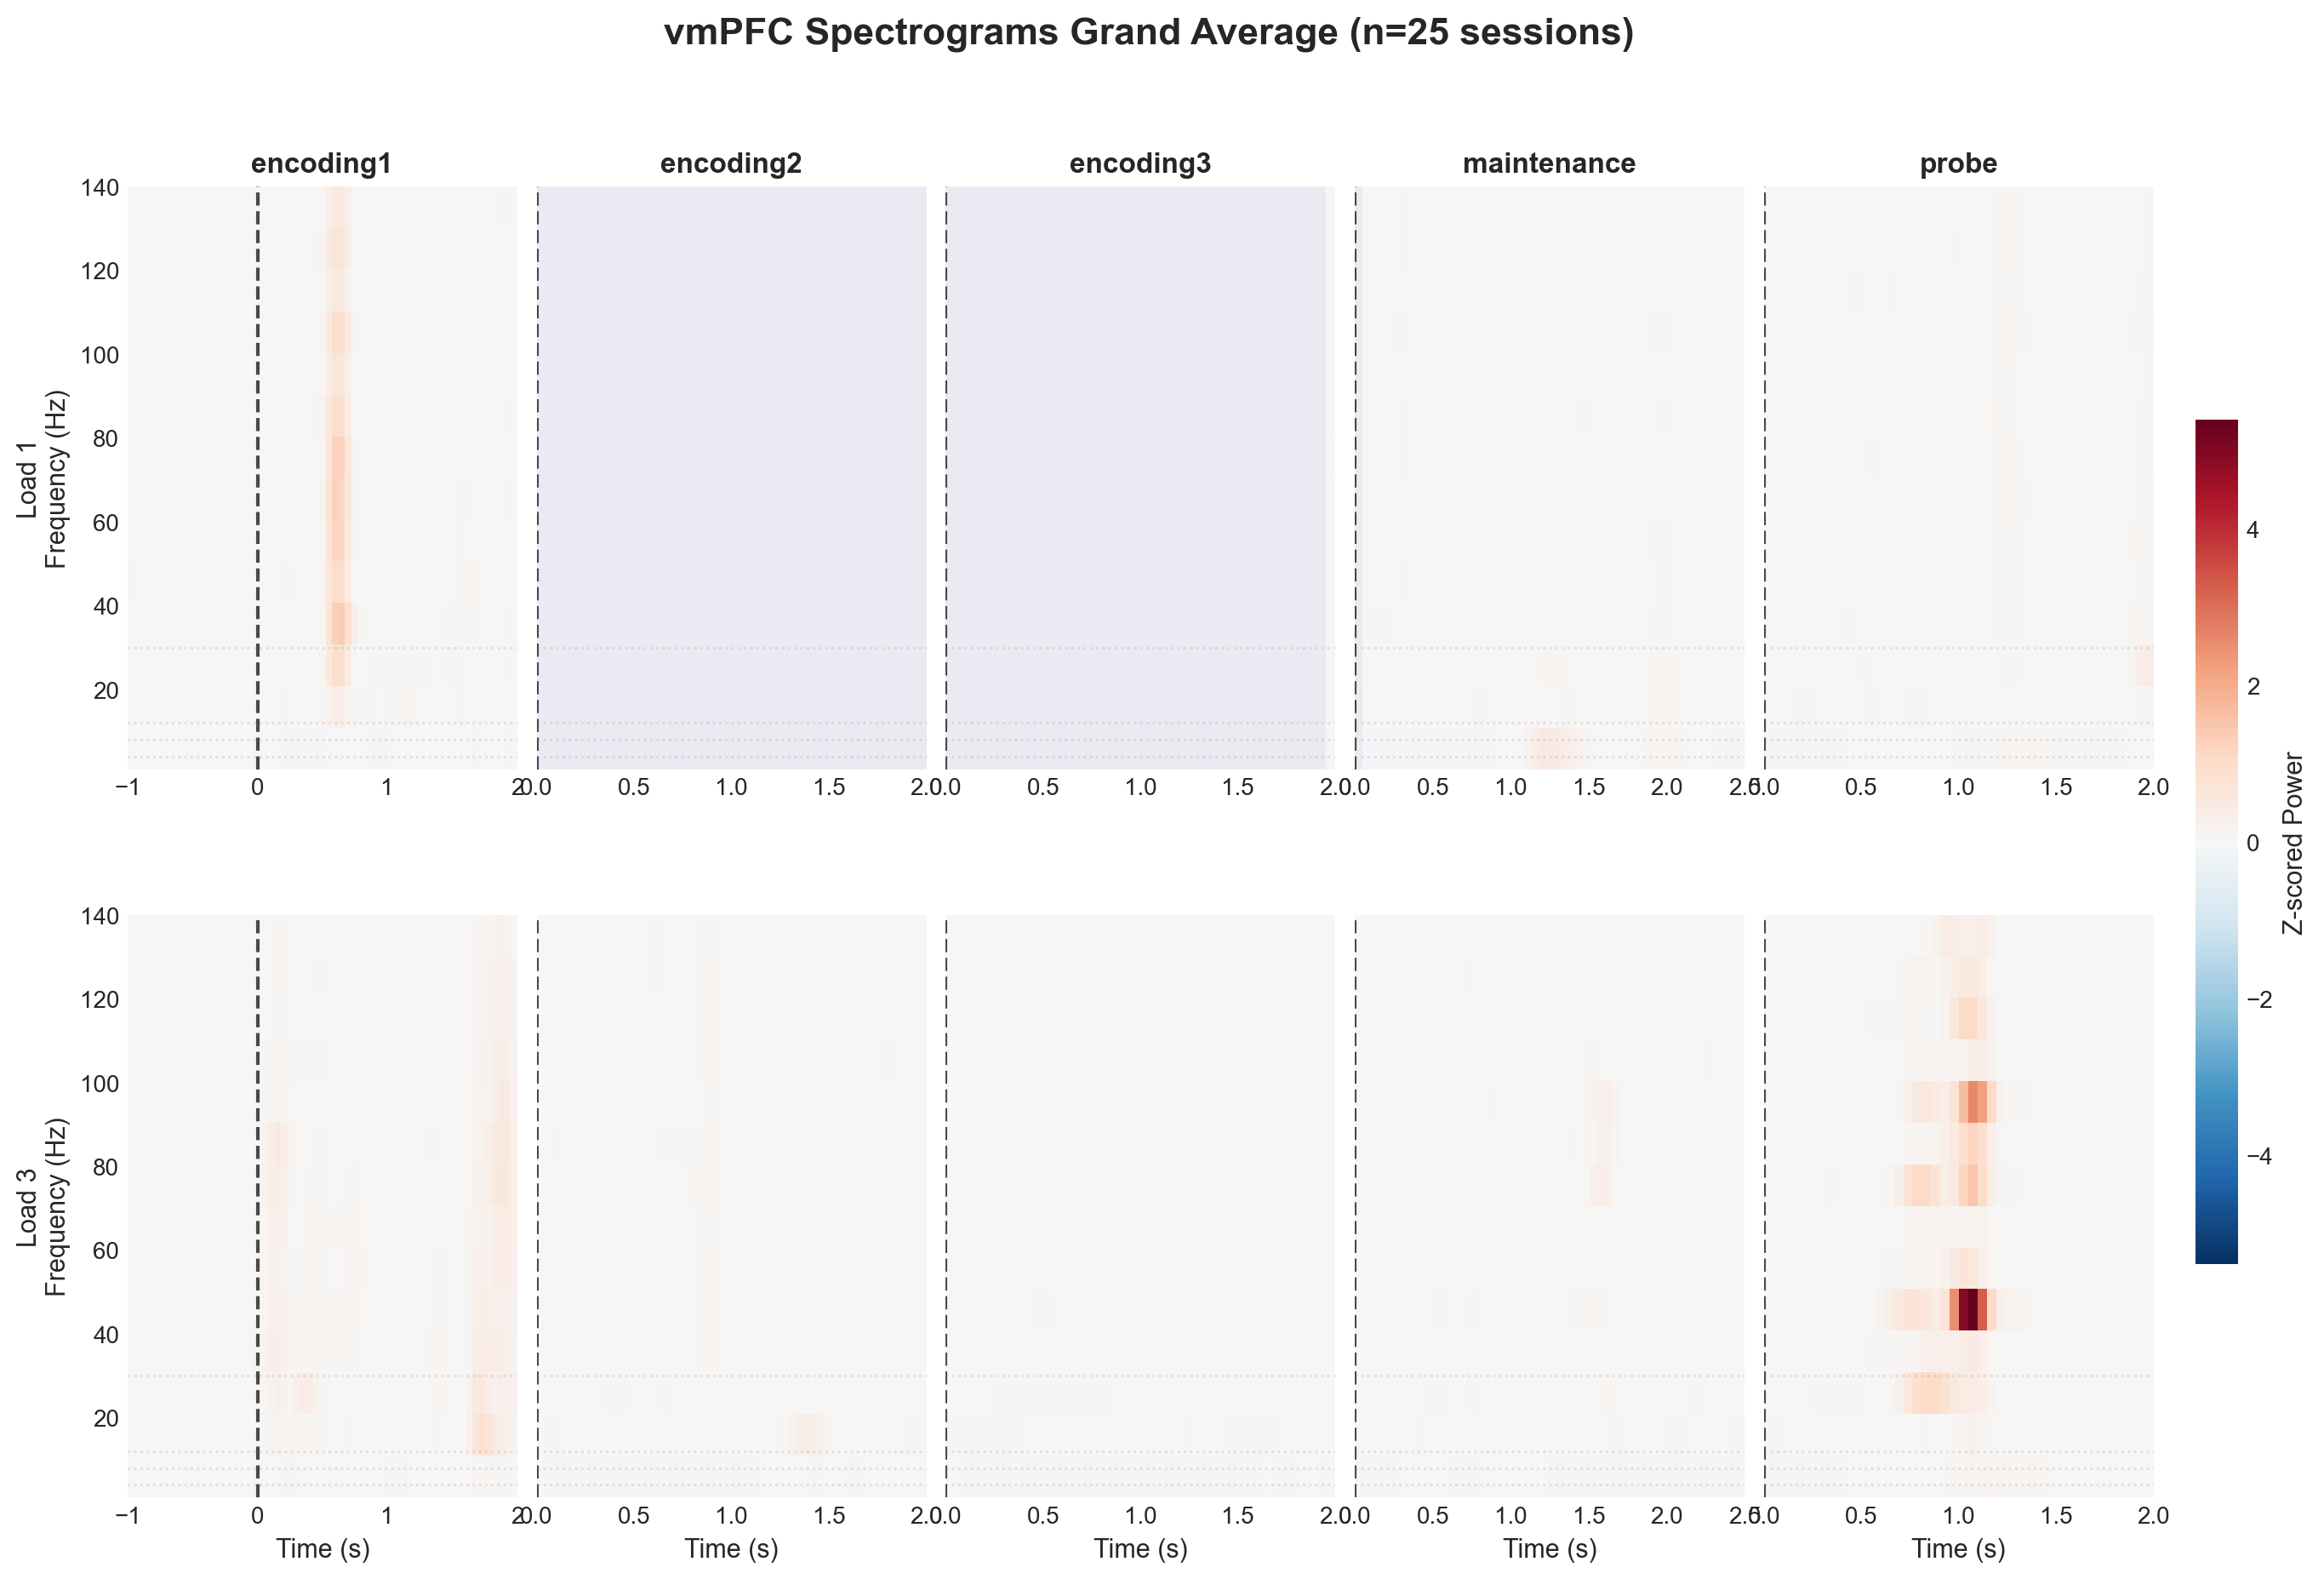

  ✓ Saved: grand_average_spectrogram_load1_vs_load3_vmPFC_n25.png

Plotting dACC...


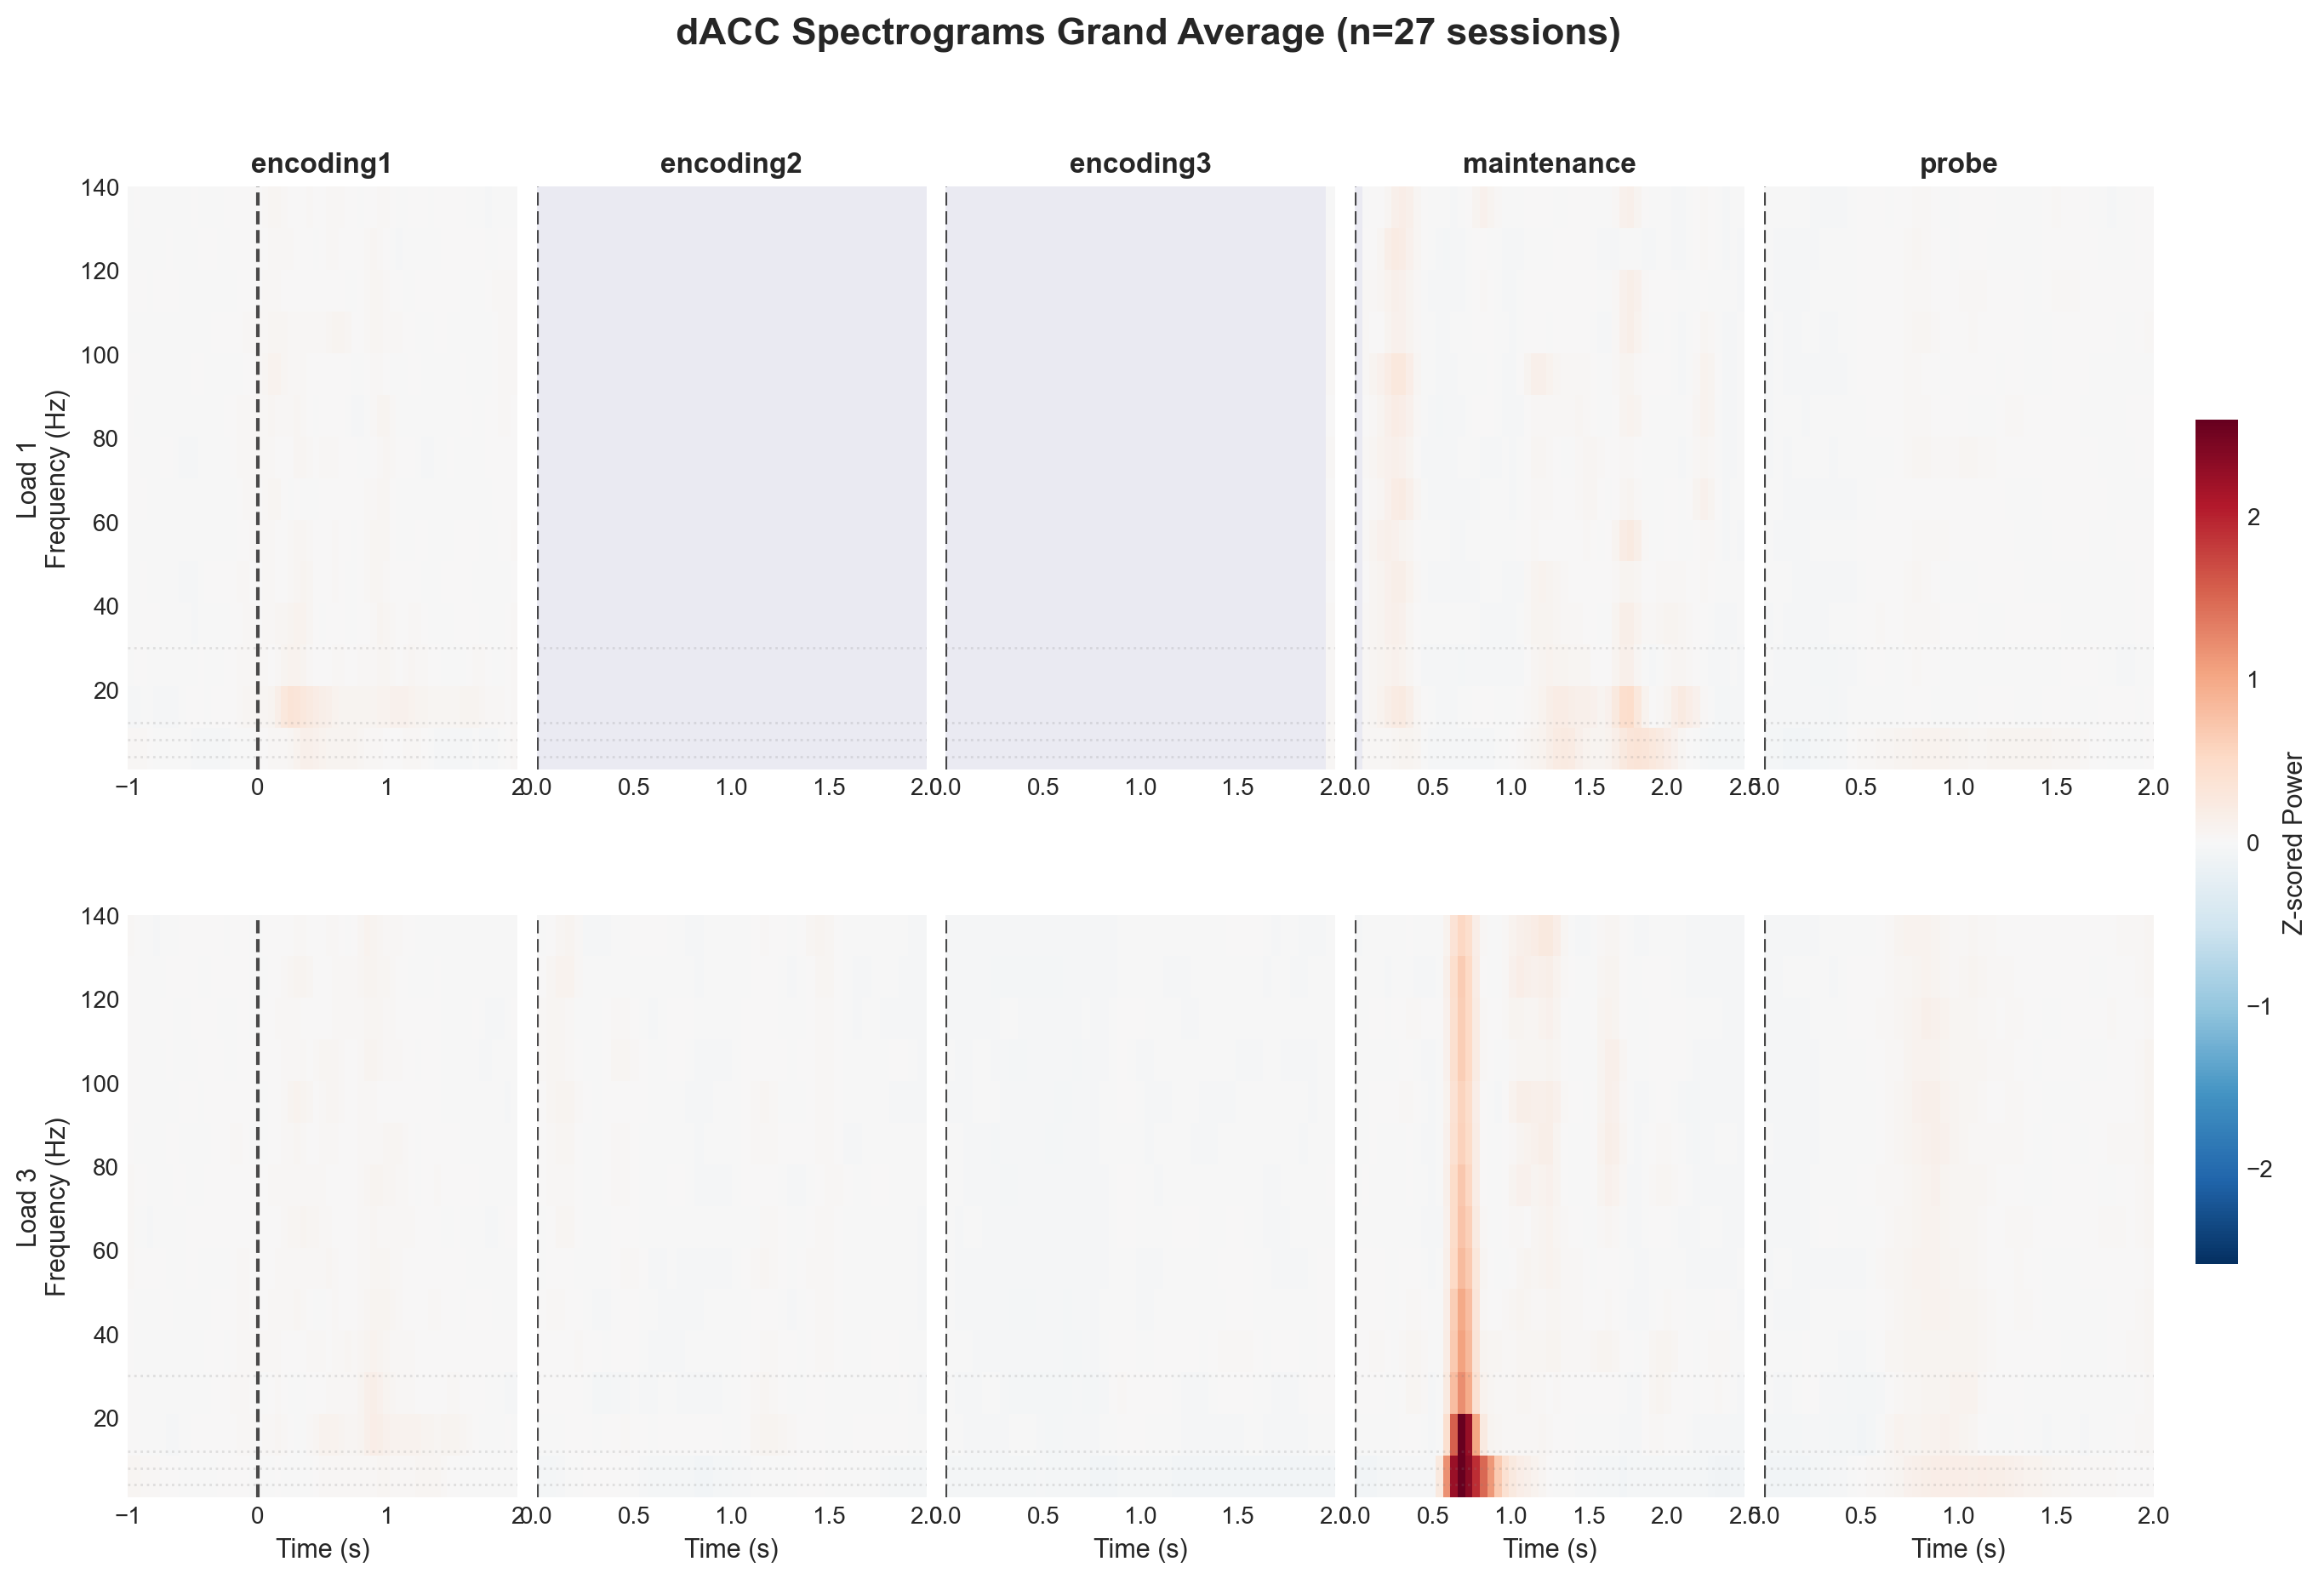

  ✓ Saved: grand_average_spectrogram_load1_vs_load3_dACC_n27.png

Plotting preSMA...


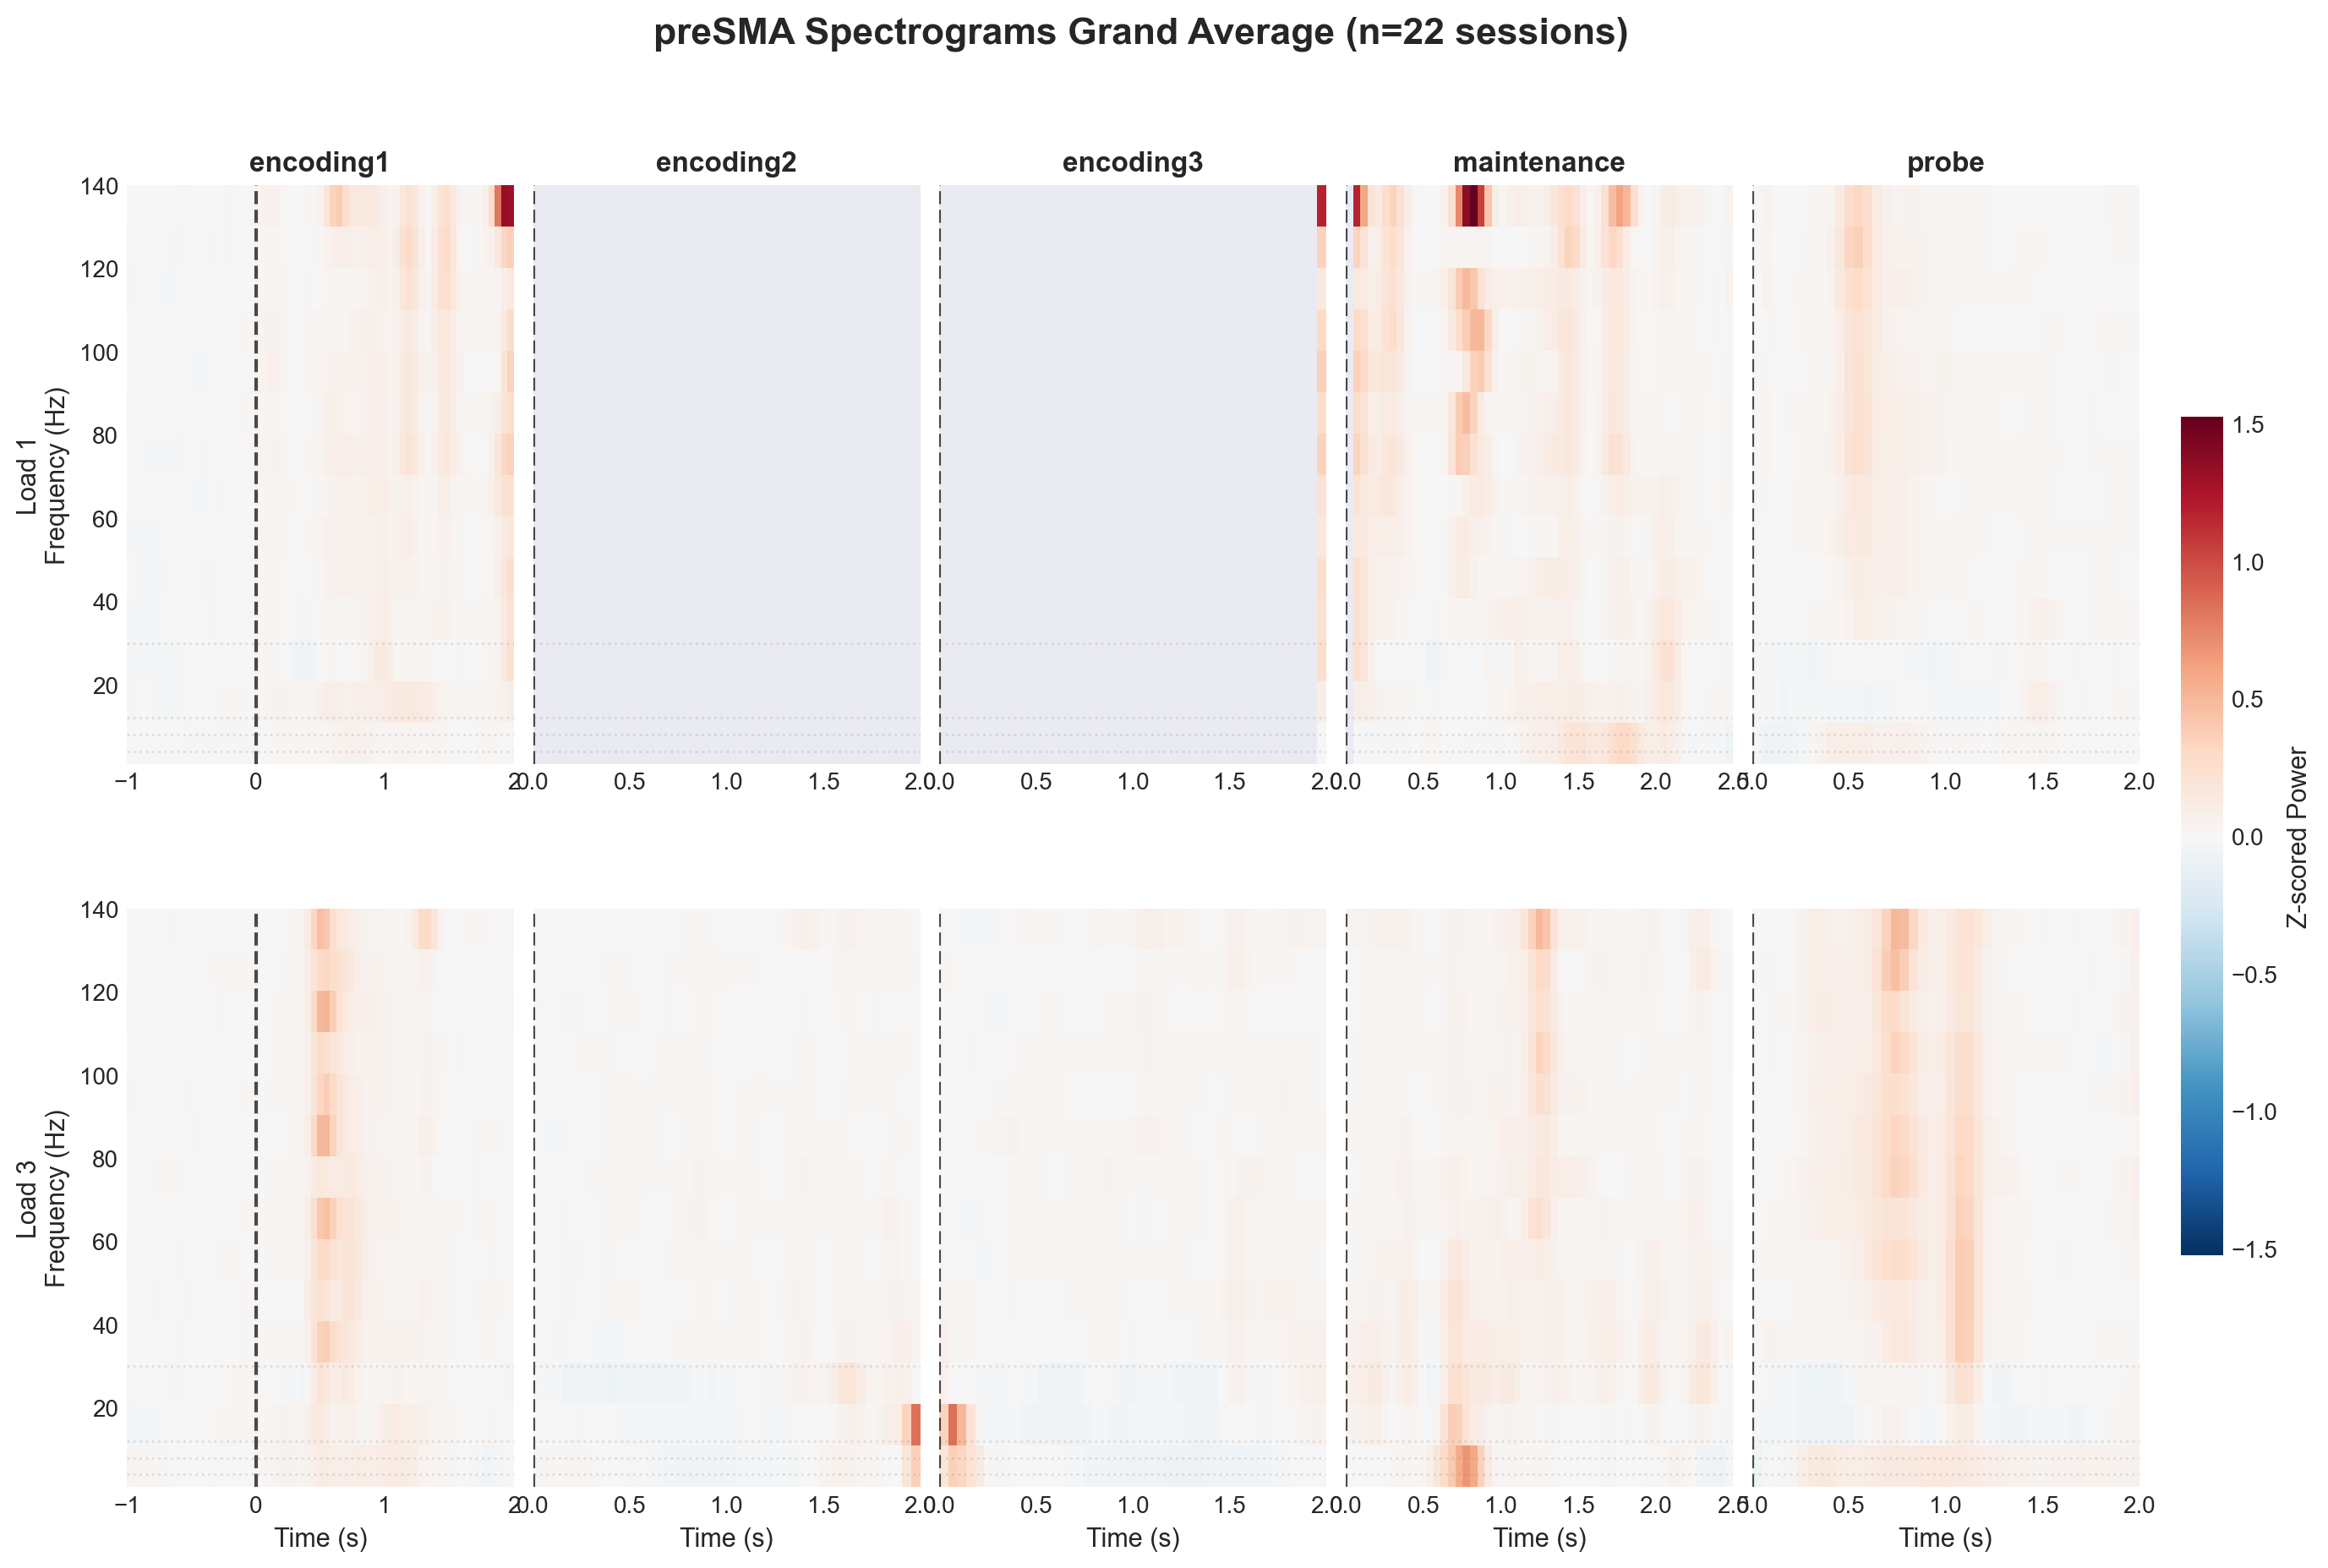

  ✓ Saved: grand_average_spectrogram_load1_vs_load3_preSMA_n22.png

✓ GRAND-AVERAGED ANALYSIS COMPLETE!


In [18]:
# Step 4: Plot grand-averaged results using existing plot function
from nwb_analysis import plot_spectrogram_by_groups

print()
print("="*70)
print("STEP 4: PLOTTING GRAND-AVERAGED RESULTS")
print("="*70)
print()

for region_name in regions_to_analyze:
    if region_name not in grand_averaged_results:
        print(f"Skipping {region_name}: no data")
        continue
    
    result = grand_averaged_results[region_name]
    
    # Reconstruct spectrogram_results structure compatible with plot function
    # This matches the format expected by plot_spectrogram_by_groups()
    reconstructed_results = {
        'groups': [
            {
                'time_vector': result['times'],
                'frequencies': result['freqs'],
                'power_zscored': result['load_1'],
                'n_trials': sum(pooled_spectrograms[region_name]['n_trials_per_session']['load_1']),
                'event_times': {},  # Will be filled from first session
                'event_boundaries': {},
                'event_sequence': [],
                'region': region_name
            },
            {
                'time_vector': result['times'],
                'frequencies': result['freqs'],
                'power_zscored': result['load_3'],
                'n_trials': sum(pooled_spectrograms[region_name]['n_trials_per_session']['load_3']),
                'event_times': {},
                'event_boundaries': {},
                'event_sequence': [],
                'region': region_name
            }
        ],
        'meta': {
            'event_boundaries': {},
            'event_sequence': [],
            'region': region_name
        }
    }
    
    # Get event information from first session's data (need to recompute)
    # For now, use empty event markers
    from nwb_analysis import EVENT_DEFINITIONS, EVENT_SEQUENCE
    
    # Compute event boundaries from config
    event_offsets = {}
    cumulative_offset = 0.0
    event_boundaries = {}
    
    for event_name in EVENT_SEQUENCE:
        window_start, window_end = EVENT_DEFINITIONS[event_name]['window']
        duration_sec = window_end - window_start
        event_offsets[event_name] = cumulative_offset
        global_start = cumulative_offset + window_start
        global_end = cumulative_offset + window_end
        event_boundaries[event_name] = (global_start, global_end)
        cumulative_offset += max(duration_sec, 0)
    
    # Update both groups and meta
    for group in reconstructed_results['groups']:
        group['event_boundaries'] = event_boundaries
        group['event_sequence'] = EVENT_SEQUENCE
        group['event_times'] = event_offsets
    
    reconstructed_results['meta']['event_boundaries'] = event_boundaries
    reconstructed_results['meta']['event_sequence'] = EVENT_SEQUENCE
    
    # Plot
    print(f"\nPlotting {region_name}...")
    fig = plot_spectrogram_by_groups(
        reconstructed_results,
        figsize=(16, 10),
        group_labels=('Load 1', 'Load 3'),
        title_suffix=f'Grand Average (n={result["n_sessions"]} sessions)',
        data_type='zscored'
    )
    
    if fig is not None:
        # Save
        filename = f'grand_average_spectrogram_load1_vs_load3_{region_name}_n{result["n_sessions"]}.png'
        save_path = OUTPUT_DIR / filename
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"  ✓ Saved: {filename}")
    else:
        print(f"  ✗ Plot failed")

print()
print("="*70)
print("✓ GRAND-AVERAGED ANALYSIS COMPLETE!")
print("="*70)

## 12. Time-Resolved Band Power During Working Memory Task

This section extracts time-resolved induced power within specific frequency bands, showing how band-limited power evolves over the task time course. Unlike the full time-frequency spectrograms, these plots show the temporal dynamics of specific oscillatory bands with **channel-level statistical error estimates**.

**Analysis approach**:
1. Extract band-averaged power from pooled **channel-level** spectrograms (from Section 11)
2. Compute mean and SEM **across channels** (statistical unit = recording electrode)
3. Plot event-aligned timecourses with Load 1 vs Load 3 comparison
4. Display as line plots (mean ± SEM) with event-based panel layout

**Statistical approach**:
- Each channel provides one trial-averaged spectrogram per condition
- Statistics computed across channels (e.g., 14 channels from Hippocampus)
- Avoids pseudo-replication (trials from same electrode aren't treated as independent)
- With 1 session: n=14 channels → visible error bars!
- With 10 sessions: n=140 channels → very stable error estimates!

In [19]:
# Define frequency bands for band-power analysis

POWER_BANDS = {
    'theta': (3, 8),
    # 'beta': (20, 35),
    'gamma': (30, 140),
    # 'high_gamma': (100, 140),
}

print("="*70)
print("FREQUENCY BANDS FOR BAND POWER ANALYSIS")
print("="*70)
print()
print("Defined frequency bands:")
for band_name, (f_low, f_high) in POWER_BANDS.items():
    print(f"  {band_name:20s}: {f_low:3d} - {f_high:3d} Hz")
print()
print(f"Number of bands: {len(POWER_BANDS)}")
print(f"Number of regions: {len(regions_to_analyze)}")
print(f"Total plots to generate: {len(POWER_BANDS)} x {len(regions_to_analyze)} = {len(POWER_BANDS) * len(regions_to_analyze)}")
print("="*70)

FREQUENCY BANDS FOR BAND POWER ANALYSIS

Defined frequency bands:
  theta               :   3 -   8 Hz
  gamma               :  30 - 140 Hz

Number of bands: 2
Number of regions: 5
Total plots to generate: 2 x 5 = 10


In [20]:
def compute_band_power_timecourse(pooled_spectrograms, region_name, freq_band):
    """
    Extract and average power within a frequency band from pooled spectrograms.
    
    Parameters
    ----------
    pooled_spectrograms : dict
        The pooled spectrogram data from Section 11 (channel-level)
    region_name : str
        Brain region name
    freq_band : tuple
        (f_low, f_high) frequency range in Hz
    
    Returns
    -------
    dict with keys:
        'load1_mean': (n_times,) mean power across channels for Load 1
        'load1_sem': (n_times,) SEM across channels for Load 1
        'load3_mean': (n_times,) mean power across channels for Load 3
        'load3_sem': (n_times,) SEM across channels for Load 3
        'times': (n_times,) time vector
        'n_channels': number of channels
        'freq_indices': frequency indices used for averaging
    
    Returns None if insufficient data.
    """
    # Check if region has data
    if region_name not in pooled_spectrograms:
        return None
    
    region_data = pooled_spectrograms[region_name]
    
    # Check if region has spectrograms
    if len(region_data['load_1_specs']) == 0:
        return None
    
    # Get frequency and time vectors
    freqs = region_data['freqs']
    times = region_data['times']
    
    if freqs is None or times is None:
        return None
    
    # Find frequency indices within the band
    f_low, f_high = freq_band
    freq_mask = (freqs >= f_low) & (freqs <= f_high)
    freq_indices = np.where(freq_mask)[0]
    
    if len(freq_indices) == 0:
        print(f"  Warning: No frequencies found in range {f_low}-{f_high} Hz")
        print(f"  Available frequency range: {freqs[0]:.1f}-{freqs[-1]:.1f} Hz")
        return None
    
    # Get spectrograms: list of (n_freqs, n_times) arrays (one per channel)
    load1_specs = region_data['load_1_specs']
    load3_specs = region_data['load_3_specs']
    
    # Convert to arrays: (n_channels, n_freqs, n_times)
    load1_specs_array = np.array(load1_specs)
    load3_specs_array = np.array(load3_specs)
    
    # Average across frequency band: (n_channels, n_times)
    load1_band_power = np.nanmean(load1_specs_array[:, freq_indices, :], axis=1)
    load3_band_power = np.nanmean(load3_specs_array[:, freq_indices, :], axis=1)
    
    # Compute mean and SEM across channels: (n_times,)
    load1_mean = np.nanmean(load1_band_power, axis=0)
    load1_sem = np.nanstd(load1_band_power, axis=0) / np.sqrt(load1_band_power.shape[0])
    
    load3_mean = np.nanmean(load3_band_power, axis=0)
    load3_sem = np.nanstd(load3_band_power, axis=0) / np.sqrt(load3_band_power.shape[0])
    
    return {
        'load1_mean': load1_mean,
        'load1_sem': load1_sem,
        'load3_mean': load3_mean,
        'load3_sem': load3_sem,
        'times': times,
        'n_channels': load1_band_power.shape[0],
        'freq_indices': freq_indices,
        'freqs_in_band': freqs[freq_indices]
    }

print("✓ Band power timecourse extraction function defined!")

✓ Band power timecourse extraction function defined!


In [21]:
def plot_band_power_by_groups(band_power_data, event_boundaries, event_sequence, 
                              band_name, region_name, figsize=(18, 4)):
    """
    Plot band power timecourse with event-aligned layout.
    
    Parameters
    ----------
    band_power_data : dict
        Output from compute_band_power_timecourse()
    event_boundaries : dict
        {event_name: (start_time, end_time)} in global time
    event_sequence : list
        Ordered list of event names
    band_name : str
        Name of frequency band (for title)
    region_name : str
        Brain region name (for title)
    figsize : tuple
        Figure size (width, height)
    
    Returns
    -------
    fig : matplotlib.figure.Figure
    """
    from nwb_analysis import EVENT_DEFINITIONS
    
    # Extract data
    times = band_power_data['times']
    load1_mean = band_power_data['load1_mean']
    load1_sem = band_power_data['load1_sem']
    load3_mean = band_power_data['load3_mean']
    load3_sem = band_power_data['load3_sem']
    n_channels = band_power_data['n_channels']
    freqs_in_band = band_power_data['freqs_in_band']
    
    # Create subplots - one per event
    n_events = len(event_sequence)
    fig, axes = plt.subplots(1, n_events, figsize=figsize, sharey=True)
    
    if n_events == 1:
        axes = [axes]
    
    # Plot each event
    for ax_idx, event_name in enumerate(event_sequence):
        ax = axes[ax_idx]
        
        # Get event boundaries
        event_start, event_end = event_boundaries[event_name]
        
        # Find time indices within this event
        time_mask = (times >= event_start) & (times <= event_end)
        time_indices = np.where(time_mask)[0]
        
        if len(time_indices) == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=10, color='gray')
            ax.set_title(event_name.replace('_', ' ').title(), fontsize=10, fontweight='bold')
            continue
        
        # Extract event-specific data
        event_times = times[time_indices]
        event_load1_mean = load1_mean[time_indices]
        event_load1_sem = load1_sem[time_indices]
        event_load3_mean = load3_mean[time_indices]
        event_load3_sem = load3_sem[time_indices]
        
        # Get event window from EVENT_DEFINITIONS for x-axis limits
        event_config = EVENT_DEFINITIONS.get(event_name, {})
        window_start, window_end = event_config.get('window', (0.0, 2.0))
        
        # Convert to event-relative time (adjust by window_start to get times relative to event timestamp)
        event_relative_times = event_times - event_start + window_start
        
        # Plot Load 1 (blue)
        ax.plot(event_relative_times, event_load1_mean, 
               color='#3498db', linewidth=2, label='Load 1', alpha=0.9)
        ax.fill_between(event_relative_times, 
                       event_load1_mean - event_load1_sem,
                       event_load1_mean + event_load1_sem,
                       color='#3498db', alpha=0.2)
        
        # Plot Load 3 (red)
        ax.plot(event_relative_times, event_load3_mean,
               color='#e74c3c', linewidth=2, label='Load 3', alpha=0.9)
        ax.fill_between(event_relative_times,
                       event_load3_mean - event_load3_sem,
                       event_load3_mean + event_load3_sem,
                       color='#e74c3c', alpha=0.2)
        
        # Add zero line
        ax.axhline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.3)
        
        # Styling
        ax.set_title(event_name.replace('_', ' ').title(), fontsize=10, fontweight='bold')
        ax.set_xlabel('Time (s)', fontsize=9)
        ax.grid(True, alpha=0.2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Set x-axis limits using the event window from EVENT_DEFINITIONS
        ax.set_xlim(window_start, window_end)
        
        # Add legend to first panel only
        if ax_idx == 0:
            ax.legend(loc='upper left', fontsize=8, framealpha=0.9)
            ax.set_ylabel('Z-scored Power', fontsize=9)
    
    # Overall title
    freq_range_str = f"{freqs_in_band[0]:.1f}-{freqs_in_band[-1]:.1f} Hz"
    fig.suptitle(f'{region_name} - {band_name.replace("_", " ").title()} ({freq_range_str}) - '
                f'Band Power Timecourse (n={n_channels} channels)',
                fontsize=12, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    return fig

print("✓ Event-aligned band power plotting function defined!")

✓ Event-aligned band power plotting function defined!



GENERATING BAND POWER TIMECOURSE PLOTS

Event boundaries computed:
  encoding1      :  -1.00 -   2.00 s
  encoding2      :   3.00 -   5.00 s
  encoding3      :   5.00 -   7.00 s
  maintenance    :   7.00 -   9.50 s
  probe          :   9.50 -  11.50 s


Frequency Band: theta (3-8 Hz)

  Region: Hippocampus
  Available frequency range: 1.0-140.0 Hz
    ✗ Skipped (no data)

  Region: Amygdala
  Available frequency range: 1.0-140.0 Hz
    ✗ Skipped (no data)

  Region: vmPFC
  Available frequency range: 1.0-140.0 Hz
    ✗ Skipped (no data)

  Region: dACC
  Available frequency range: 1.0-140.0 Hz
    ✗ Skipped (no data)

  Region: preSMA
  Available frequency range: 1.0-140.0 Hz
    ✗ Skipped (no data)

Frequency Band: gamma (30-140 Hz)

  Region: Hippocampus
    Frequencies: 33.1-140.0 Hz (11 bins)
    Channels: 613


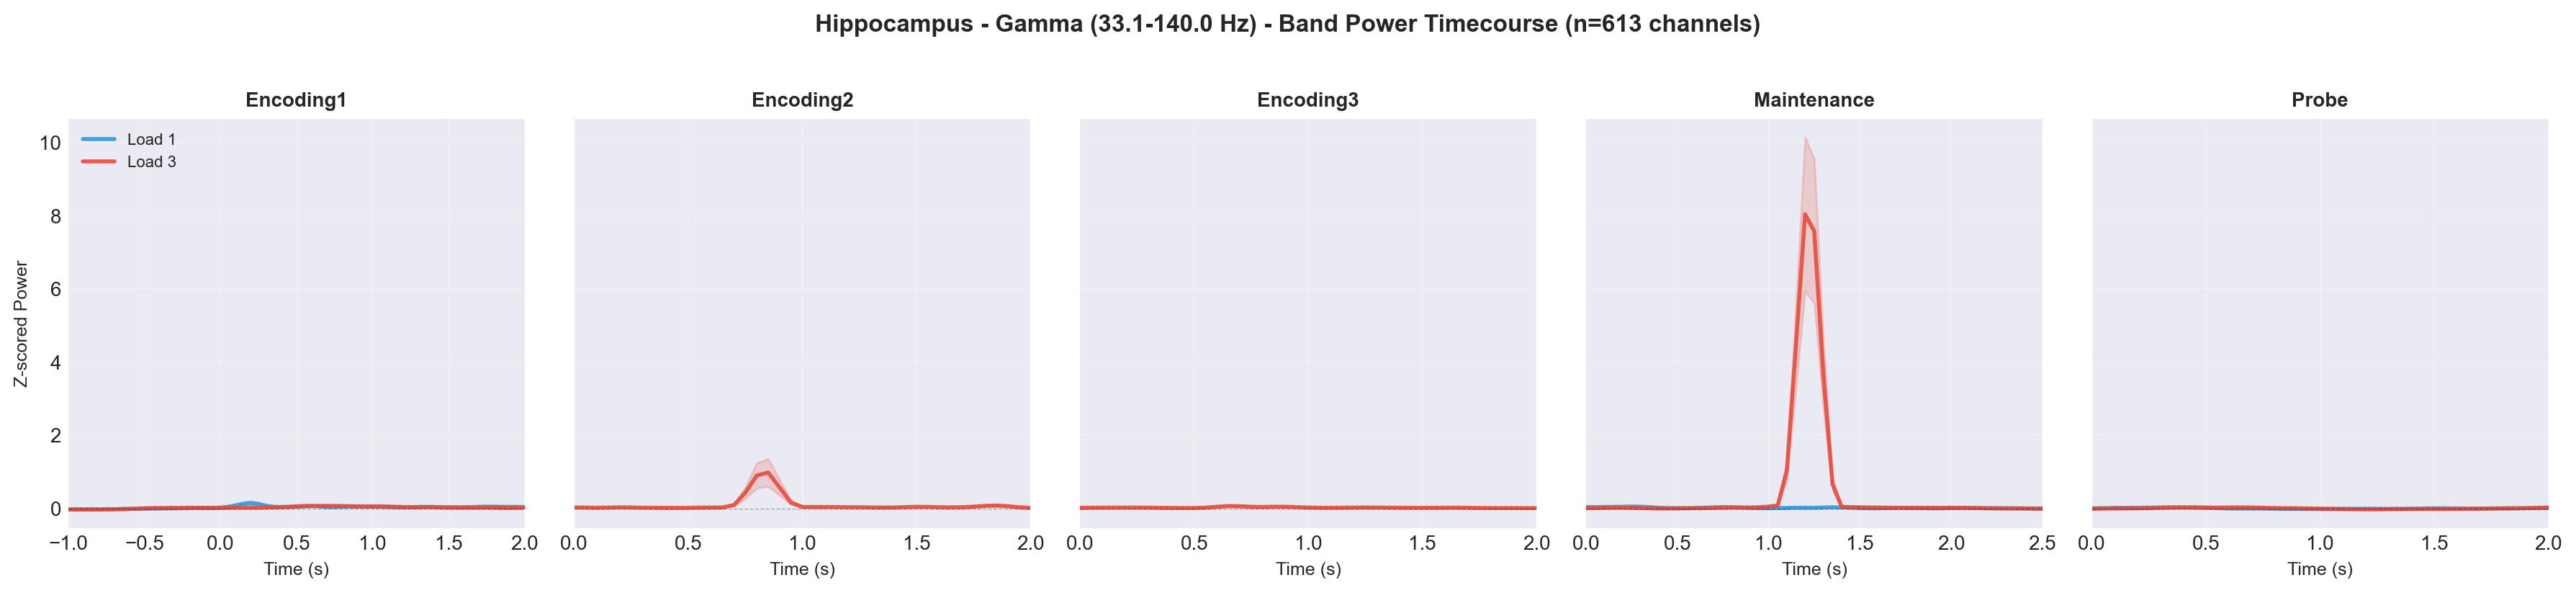

    ✓ Saved: band_power_gamma_Hippocampus_load1_vs_load3_n613ch.png

  Region: Amygdala
    Frequencies: 33.1-140.0 Hz (11 bins)
    Channels: 465


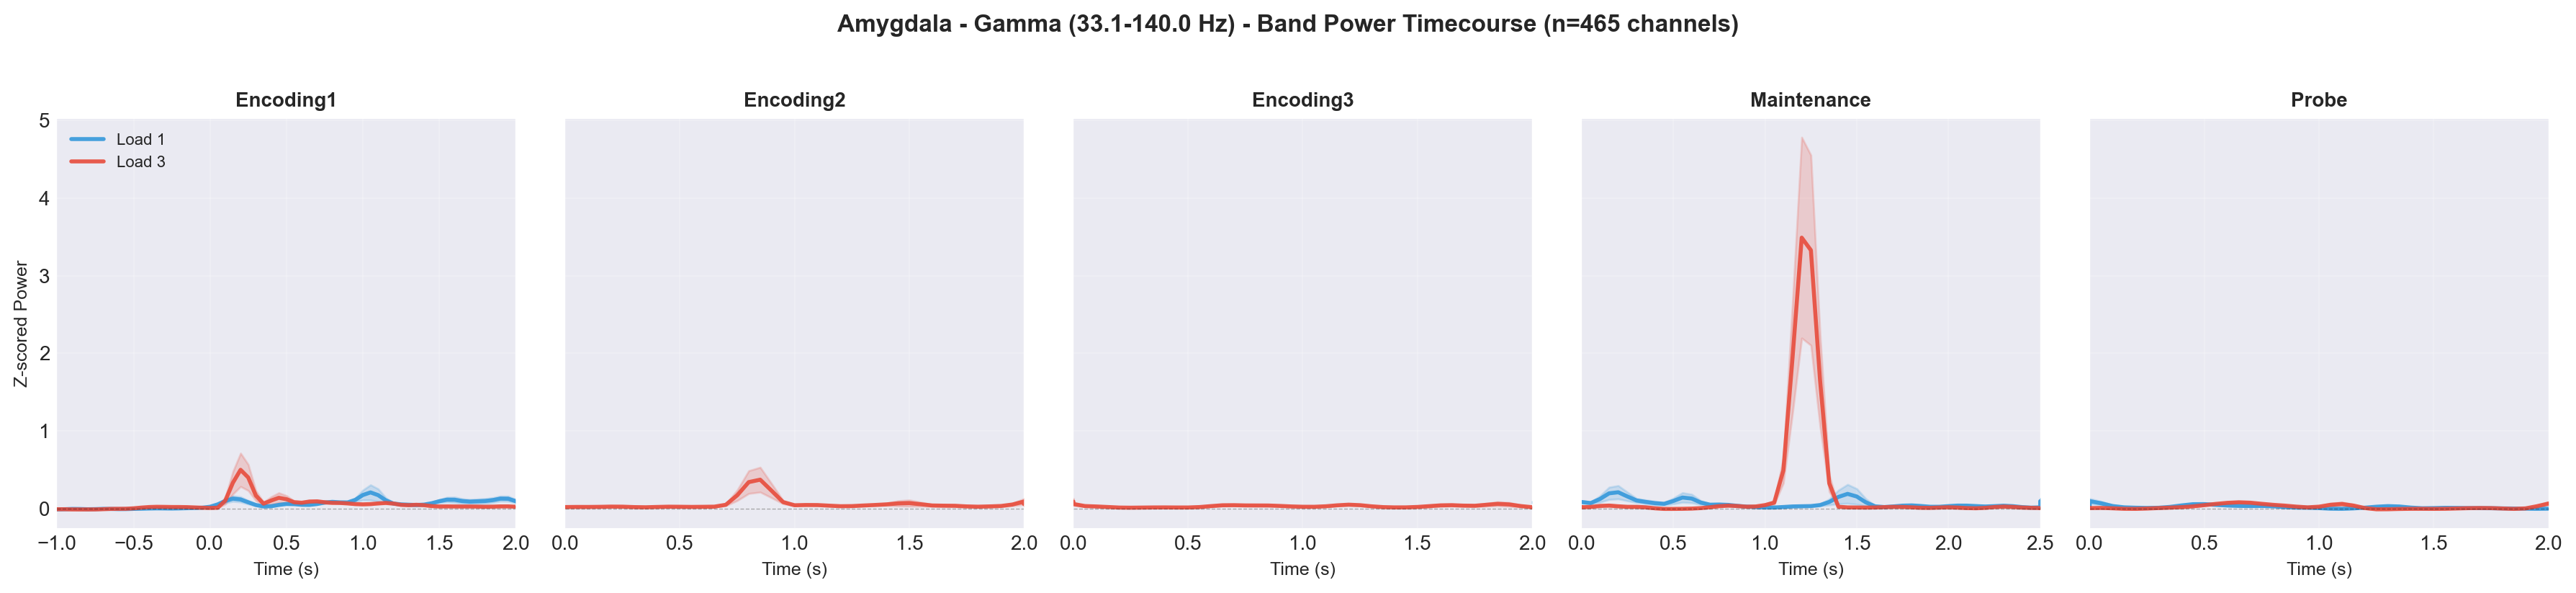

    ✓ Saved: band_power_gamma_Amygdala_load1_vs_load3_n465ch.png

  Region: vmPFC
    Frequencies: 33.1-140.0 Hz (11 bins)
    Channels: 225


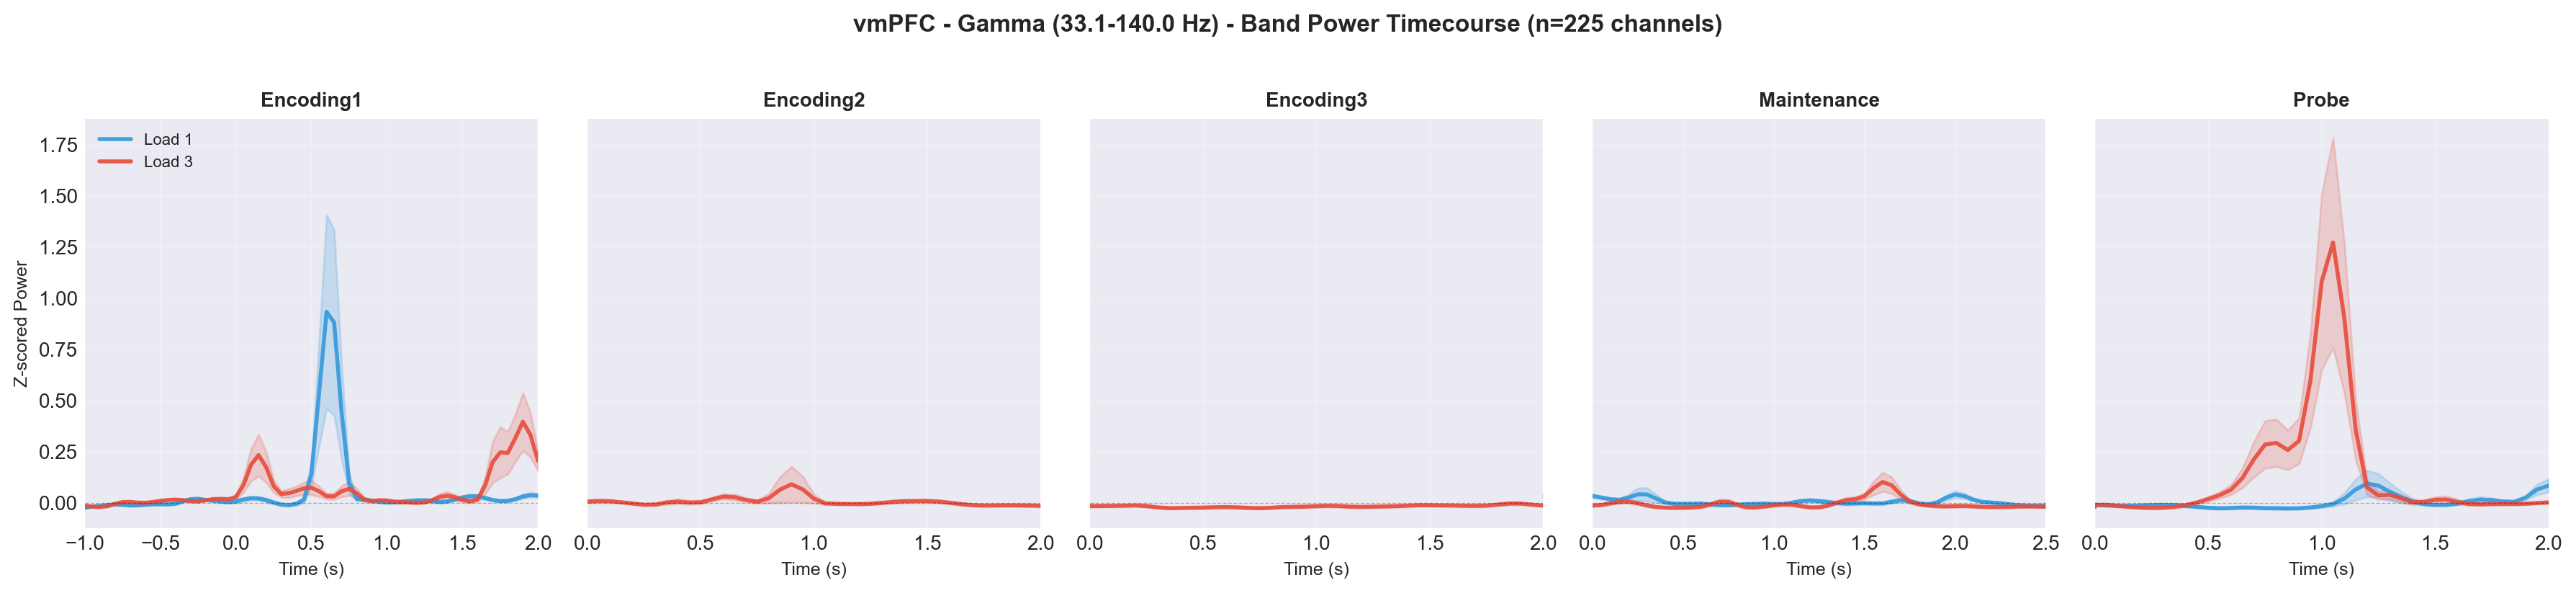

    ✓ Saved: band_power_gamma_vmPFC_load1_vs_load3_n225ch.png

  Region: dACC
    Frequencies: 33.1-140.0 Hz (11 bins)
    Channels: 330


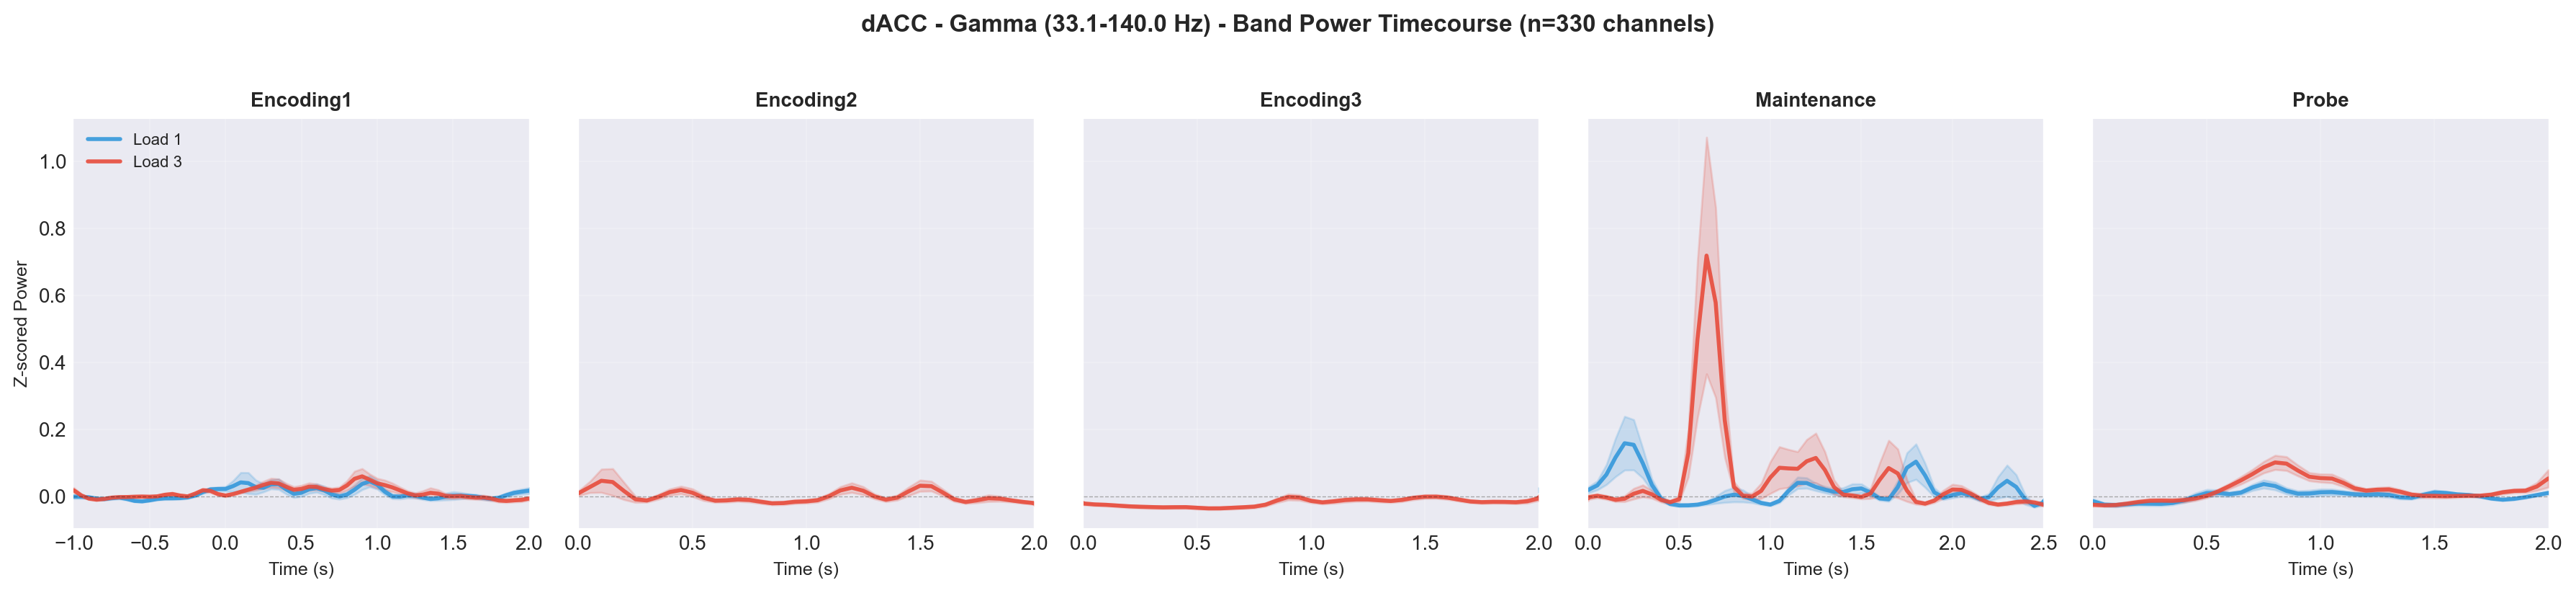

    ✓ Saved: band_power_gamma_dACC_load1_vs_load3_n330ch.png

  Region: preSMA
    Frequencies: 33.1-140.0 Hz (11 bins)
    Channels: 289


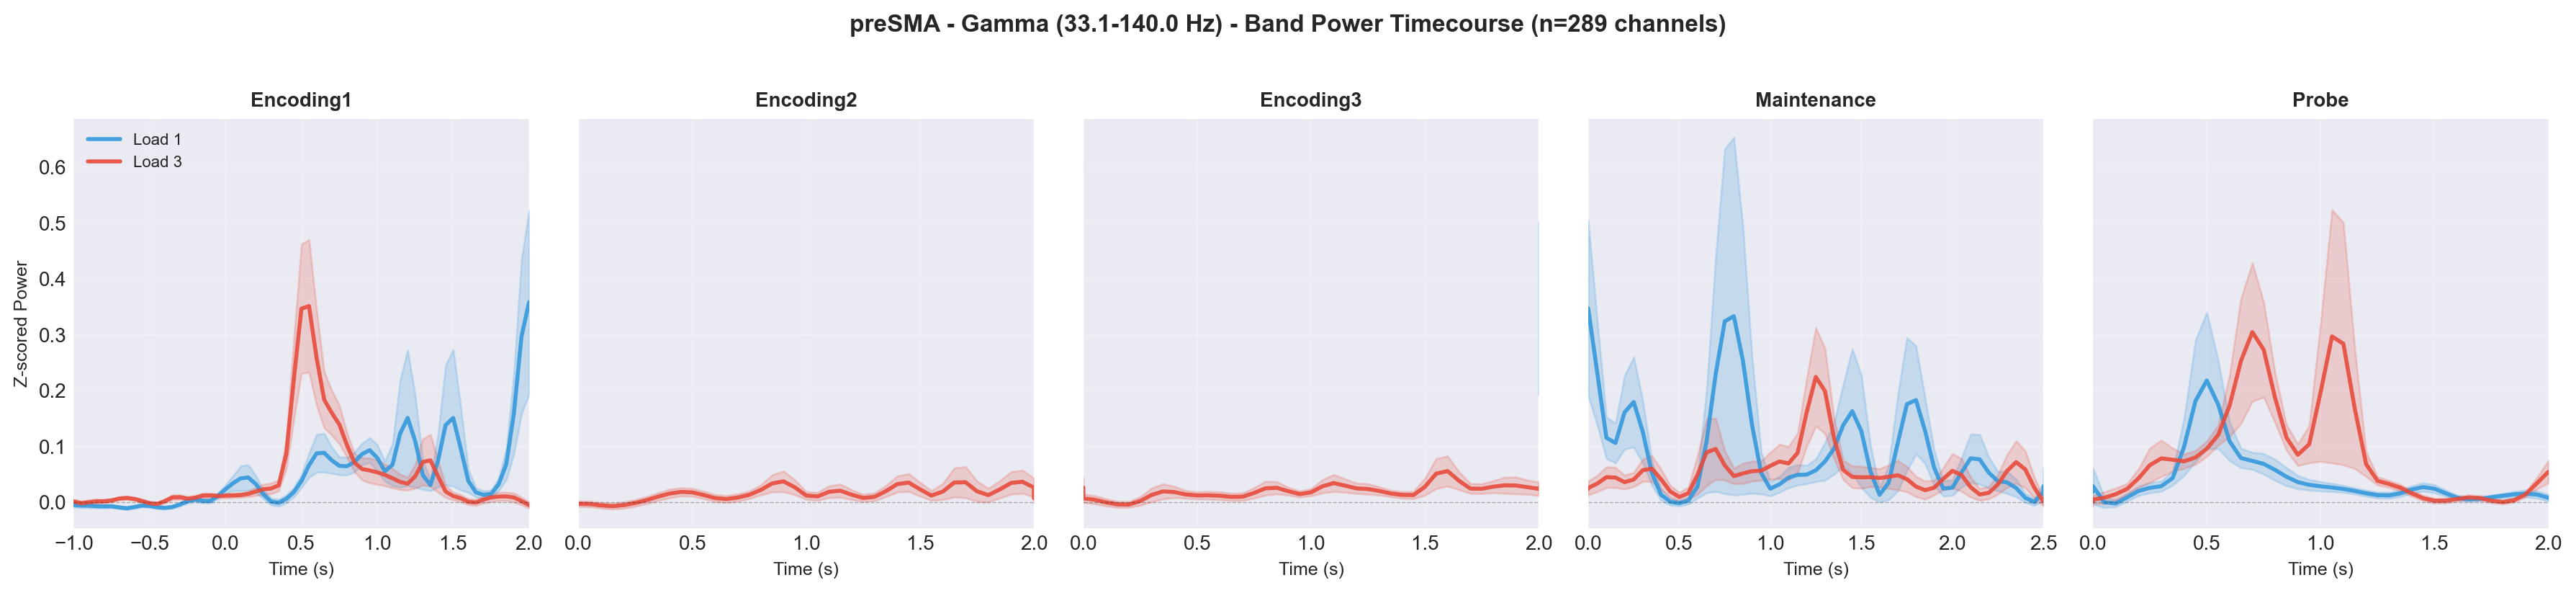

    ✓ Saved: band_power_gamma_preSMA_load1_vs_load3_n289ch.png

✓ BAND POWER TIMECOURSE ANALYSIS COMPLETE!
  Plots generated: 5
  Plots skipped: 5


In [22]:
# Generate band power timecourse plots for all bands and regions
from nwb_analysis import EVENT_DEFINITIONS, EVENT_SEQUENCE

print()
print("="*70)
print("GENERATING BAND POWER TIMECOURSE PLOTS")
print("="*70)
print()

# Compute event boundaries (reuse from Section 11)
event_offsets = {}
cumulative_offset = 0.0
event_boundaries = {}

for event_name in EVENT_SEQUENCE:
    window_start, window_end = EVENT_DEFINITIONS[event_name]['window']
    duration_sec = window_end - window_start
    event_offsets[event_name] = cumulative_offset
    global_start = cumulative_offset + window_start
    global_end = cumulative_offset + window_end
    event_boundaries[event_name] = (global_start, global_end)
    cumulative_offset += max(duration_sec, 0)

print(f"Event boundaries computed:")
for event_name in EVENT_SEQUENCE:
    start, end = event_boundaries[event_name]
    print(f"  {event_name:15s}: {start:6.2f} - {end:6.2f} s")
print()

# Counter for successful plots
n_plots_generated = 0
n_plots_skipped = 0

# Loop over frequency bands
for band_name, freq_band in POWER_BANDS.items():
    print(f"\n{'='*70}")
    print(f"Frequency Band: {band_name} ({freq_band[0]}-{freq_band[1]} Hz)")
    print(f"{'='*70}")
    
    # Loop over brain regions
    for region_name in regions_to_analyze:
        print(f"\n  Region: {region_name}")
        
        # Compute band power timecourse
        band_power_data = compute_band_power_timecourse(
            pooled_spectrograms, region_name, freq_band
        )
        
        if band_power_data is None:
            print(f"    ✗ Skipped (no data)")
            n_plots_skipped += 1
            continue
        
        # Print info
        n_freqs_in_band = len(band_power_data['freq_indices'])
        freq_range_actual = (band_power_data['freqs_in_band'][0], 
                            band_power_data['freqs_in_band'][-1])
        print(f"    Frequencies: {freq_range_actual[0]:.1f}-{freq_range_actual[1]:.1f} Hz ({n_freqs_in_band} bins)")
        print(f"    Channels: {band_power_data['n_channels']}")
        
        # Plot
        fig = plot_band_power_by_groups(
            band_power_data, event_boundaries, EVENT_SEQUENCE,
            band_name, region_name, figsize=(18, 4)
        )
        
        # Save
        filename = f'band_power_{band_name}_{region_name}_load1_vs_load3_n{band_power_data["n_channels"]}ch.png'
        save_path = OUTPUT_DIR / filename
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"    ✓ Saved: {filename}")
        n_plots_generated += 1

print()
print("="*70)
print(f"✓ BAND POWER TIMECOURSE ANALYSIS COMPLETE!")
print(f"  Plots generated: {n_plots_generated}")
print(f"  Plots skipped: {n_plots_skipped}")
print("="*70)